In [9]:
import pandas as pd
import numpy as np
from technical_indicators_lib import *
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [10]:
# Simple Average Movement 
def get_smas(stocks, names, period):
    # Erstellen des SMAs (Periode in den variablen übergeben)
    sma = SMA()
    for stock in stocks:
        stock = sma.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_sma(stocks)
    print_smas(stocks, names)
    
    
# Methode zum bewerten der SMA Ergebnisse 
def add_buy_and_sell_sma(stocks):
    for stock in stocks:
        # variable um den allgemeinen trend zu erfragen (hold, buy, sell)
        trend = [] 
        # Alle Tage an denen gebuyt wird werden mit dem Aktienkurs aufgefüllt, sonst nan
        helper_buy = []
        # Alle Tage an denen gesellt wird werden mit dem Aktienkurs aufgefüllt, sonst nan
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            # wenn undefinierte Werte erscheinen machen wir nichts
            if math.isnan(stock["SMA"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                # wenn der Aktienkurs über dem Durchschnitt (SMA) liegt
                if stock["close"][day] >= stock["SMA"][day]:
                    # Prüdung, ob wir vorher ein Buy oder Sell Rating gegeben haben (Wichtig um nachzuvollziehen wie viele tage ein Signal besteht)
                    if flag == 0: # flag == 0 bedeutet vorher ein Sell
                        # Das signal besteht zum 0ten Tag
                        days_signal_persists = 0
                        # Keine Aussagekraft, daher ein hold
                        helper_buy.append(stock["close"][day])
                        helper_sell.append(np.nan)
                        trend.append("buy")
                        flag = 1
                    else:
                        # wenn wir vorher schon im Buy waren, wird tage an dem signal besteht erhöht
                        days_signal_persists+=1
                        # wenn wir lange genug ein Signal haben kaufen wir
                        if days_signal_persists <= 1:# and days_signal_persists <= 7):
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            # sonst halten wir
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                # wenn der Kurs unter dem Durchschnitt ist
                if stock["close"][day] < stock["SMA"][day]:
                    # Abprüfung aus welchem Bereich wir kommen
                    if flag == 1:
                        # Zurücksetzen des Counters, und hold als Wert zuweisen
                        days_signal_persists=0
                        helper_buy.append(np.nan)
                        helper_sell.append(stock["close"][day])
                        trend.append("sell")
                        flag = 0
                    else:
                        # wenn das signal lange genug besteht, verkaufen wir
                        days_signal_persists+=1
                        if days_signal_persists <= 1:# and days_signal_persists <= 7): 
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            # sonst nicht
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")  
        # hinzufügen der Kaufempfehlungen an das Dataframe
        stock["sma_buy"] = helper_buy
        stock["sma_sell"] = helper_sell
        stock["sma_trend"] = trend
        
# funktion zum Ausgeben der Aktie
def print_smas(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["sma_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["sma_sell"], label="sell", marker=11, color="r")
        ax.plot(stock["SMA"], label="sma", color="y")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("SMA of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [11]:
# Relative Strength Index

def get_rsi(stocks, names, period):
    rsi = RSI()
    for stock in stocks:
        stock = rsi.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_rsi(stocks)
    print_rsi(stocks, names)

def add_buy_and_sell_rsi(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["RSI"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                if stock["RSI"][day] <= 30:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 3:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            trend.append("hold")
                if stock["RSI"][day] >= 70:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 3:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            trend.append("hold")                        
                if  stock["RSI"][day] < 70 and stock["RSI"][day] > 30:
                    helper_sell.append(np.nan)
                    helper_buy.append(np.nan)
                    trend.append("hold")
        stock["rsi_buy"] = helper_buy
        stock["rsi_sell"] = helper_sell
        stock["rsi_trend"] = trend

def print_rsi(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(2,figsize=(15,10))  # Create a figure and an axes.
        ax[0].plot(stock["close"], label="close")  # Plot some data on the axes.
        ax[0].plot(stock["rsi_buy"], label="buy", marker=10, color="g")
        ax[0].plot(stock["rsi_sell"], label="sell", marker=11, color="r")
        ax[0].set_xlabel('Time')  # Add an x-label to the axes.
        ax[0].set_ylabel('Value')  # Add a y-label to the axes.
        ax[0].set_title("RSI of "+names[counter])  # Add a title to the axes.
        ax[0].legend()  # Add a legend.
        ax[1].plot(stock["RSI"], label="RSI")  # Plot some data on the axes.
        ax[1].set_xlabel('Time')  # Add an x-label to the axes.
        ax[1].set_ylabel('Value')  # Add a y-label to the axes.
        ax[1].legend()  # Add a legend.
        counter+=1

In [12]:
# MACD
def get_macd(stocks, names, period):
    macd = MACD()
    for stock in stocks:
        stock = macd.get_value_df(stock, 12, 26, True, 9)
    #print(stocks)
    add_buy_and_sell_macd(stocks)
    print_macd(stocks, names)

    # macd needs both holds since only crosses are taking effect

def add_buy_and_sell_macd(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["MACD_signal_line"][day]) or math.isnan(stock["MACD"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:   
                    if (stock["MACD"][day] <= stock["MACD_signal_line"][day]):
                        if flag == 1:
                            days_signal_persists=0
                            helper_sell.append(stock["close"][day])
                            helper_buy.append(np.nan)
                            trend.append("sell")
                            flag = 0
                        else:
                            days_signal_persists+=1
                            if days_signal_persists >= 1 and days_signal_persists < 5:
                                helper_buy.append(np.nan)
                                helper_sell.append(np.nan)
                                trend.append("hold")
                            else:
                                helper_sell.append(np.nan)
                                helper_buy.append(np.nan)
                                trend.append("hold")                                
                    elif stock["MACD"][day] > stock["MACD_signal_line"][day]:                               
                        if flag == 0:
                            days_signal_persists = 0
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            flag = 1
                            trend.append("buy")
                        else:
                            days_signal_persists+=1
                            if days_signal_persists >= 1 and days_signal_persists < 5:
                                helper_buy.append(np.nan)
                                helper_sell.append(np.nan)
                                trend.append("hold")
                            else:
                                helper_sell.append(np.nan)
                                helper_buy.append(np.nan)
                                trend.append("hold")
        stock["macd_buy"] = helper_buy
        stock["macd_sell"] = helper_sell
        stock["macd_trend"] = trend
def print_macd(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(2,figsize=(15,10))  # Create a figure and an axes.
        ax[0].plot(stock["close"], label="close")  # Plot some data on the axes.
        ax[0].plot(stock["macd_buy"], label="buy", marker=10, color="g")
        ax[0].plot(stock["macd_sell"], label="sell", marker=11, color="r")
        ax[0].set_xlabel('Time')  # Add an x-label to the axes.
        ax[0].set_ylabel('Value')  # Add a y-label to the axes.
        ax[0].set_title("MACD of "+names[counter])  # Add a title to the axes.
        ax[0].legend()  # Add a legend.
        ax[1].plot(stock["MACD"], label="MACD")  # Plot some data on the axes.
        ax[1].plot(stock["MACD_signal_line"], label="signal line")  # Plot some data on the axes.
        ax[1].set_xlabel('Time')  # Add an x-label to the axes.
        ax[1].set_ylabel('Value')  # Add a y-label to the axes.
        ax[1].legend()  # Add a legend.
        counter+=1

In [13]:
# EMA EMA
def get_ema(stocks, names, period):
    ema = EMA()
    for stock in stocks:
        stock = ema.get_value_df(stock, period)
    add_buy_and_sell_ema(stocks)
    print_ema(stocks, names)
        
def add_buy_and_sell_ema(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["EMA"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:    
                if stock["EMA"][day] <= stock["close"][day]:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(stock["close"][day])
                        helper_sell.append(np.nan)
                        trend.append("buy")
                        flag = 1
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 1 and days_signal_persists <= 3:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                if stock["EMA"][day] > stock["close"][day]:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 4 and days_signal_persists <= 7:
                            helper_buy.append(np.nan)
                            helper_sell.append(np.nan)
                            trend.append("hold")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
        stock["ema_buy"] = helper_buy
        stock["ema_sell"] = helper_sell
        stock["ema_trend"] = trend
        
def print_ema(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["ema_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["ema_sell"], label="sell", marker=11, color="r")
        ax.plot(stock["EMA"], label="ema", color="y")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("EMA of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [14]:
# Stochastik StochasticKAndD
def get_stoch(stocks, names, period):
    stoch = StochasticKAndD()
    for stock in stocks:
        stock = stoch.get_value_df(stock, period)
    #print(stocks)
    add_buy_and_sell_stoch(stocks)
    print_stoch(stocks, names)


def add_buy_and_sell_stoch(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["stoc_d"][day]) or math.isnan(stock["stoc_k"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:   
                if stock["stoc_k"][day] <= 20 or stock["stoc_d"][day] <= 20:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 1 and days_signal_persists <= 4:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                elif stock["stoc_k"][day] >= 80 or stock["stoc_d"][day] >= 80:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 1 and days_signal_persists <= 4:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                else:
                    helper_buy.append(np.nan)
                    helper_sell.append(np.nan)
                    trend.append("hold")
        stock["stoch_buy"] = helper_buy
        stock["stoch_sell"] = helper_sell
        stock["stoch_trend"] = trend
        
def print_stoch(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(2, figsize=(15,10))  # Create a figure and an axes.
        ax[0].plot(stock["close"], label="close")  # Plot some data on the axes.
        ax[0].plot(stock["stoch_buy"], label="buy", marker=10, color="g")
        ax[0].plot(stock["stoch_sell"], label="sell", marker=11, color="r")
        ax[0].set_xlabel('Time')  # Add an x-label to the axes.
        ax[0].set_ylabel('Value')  # Add a y-label to the axes.
        ax[0].set_title("Stochastik K%D of "+names[counter])  # Add a title to the axes.
        ax[0].legend()  # Add a legend.
        ax[1].plot(stock["stoc_d"], label="stoc_d")  # Plot some data on the axes.
        ax[1].plot(stock["stoc_k"], label="stoc_k")  # Plot some data on the axes.
        ax[1].set_xlabel('Time')  # Add an x-label to the axes.
        ax[1].set_ylabel('Value')  # Add a y-label to the axes.
        ax[1].legend()  # Add a legend.
        counter+=1

In [15]:
# OBV (on balance volume)

def get_obv(stocks, names, period):
    obv = OBV()
    for stock in stocks:
        stock = obv.get_value_df(stock)
    #print(stocks)
    add_average_obv(stocks, period)
    add_buy_and_sell_obv(stocks)
    print_obv(stocks, names)

def add_average_obv(stocks, period):
    for stock in stocks:
        lookback = period
        values = []
        length = len(stock["close"])
        for day in range(length):
            if day <= lookback:
                values.append(np.nan)
            else:
                helper = stock[day-lookback:day]["OBV"].values
                values.append(np.mean(helper))
        stock["OBV_average"] = values

def add_buy_and_sell_obv(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        length = len(stock["close"])
        for day in range (length):
            if not np.isnan(stock["OBV_average"][day]) and not np.isnan(stock["OBV_average"][day-1]): 
                # korridore hinzufügen etwa 10 % schewankung soll auf  hold fallen ( wenn volumen mehr als 5 % mehr ist dann erst buy, oder eben sell)
                if stock["OBV"][day] >= stock["OBV_average"][day-1]:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 3 and days_signal_persists <= 5:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                elif stock["OBV"][day] < stock["OBV_average"][day-1]:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 3 and days_signal_persists <= 5:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")   
                else:
                    helper_buy.append(np.nan)
                    helper_sell.append(np.nan)
                    trend.append("hold")
            else:
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
        stock["obv_buy"] = helper_buy
        stock["obv_sell"] = helper_sell
        stock["obv_trend"] = trend
        
def print_obv(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(2, figsize=(15,10))  # Create a figure and an axes.
        ax[0].plot(stock["close"], label="close")  # Plot some data on the axes.
        ax[0].plot(stock["obv_buy"], label="buy", marker=10, color="g")
        ax[0].plot(stock["obv_sell"], label="sell", marker=11, color="r")
        ax[0].set_xlabel('Time')  # Add an x-label to the axes.
        ax[0].set_ylabel('Value')  # Add a y-label to the axes.
        ax[0].set_title("reccomandations from OBV for "+names[counter])  # Add a title to the axes.
        ax[0].legend()  # Add a legend.
        ax[1].plot(stock["OBV"], label="OBV")  # Plot some data on the axes.
        ax[1].plot(stock["OBV_average"], label="average")  # Plot some data on the axes.
        ax[1].set_xlabel('Time')  # Add an x-label to the axes.
        ax[1].set_ylabel('Value')  # Add a y-label to the axes.
        ax[1].legend()  # Add a legend.
        counter+=1

In [16]:
# Bolliunger bands

def get_bb(stocks, names, period):
    bb = BollingerBands()
    for stock in stocks:
        stock = bb.get_value_df(stock, period, 2)
    #print(stocks)
    add_buy_and_sell_bb(stocks)
    print_bb(stocks, names)


def add_buy_and_sell_bb(stocks):
     for stock in stocks:
        trend = []
        helper_buy = []
        helper_sell = []
        flag = 0
        days_signal_persists = 0
        for day in stock.index:
            if math.isnan(stock["bb_lower"][day]) or math.isnan(stock["bb_upper"][day]): 
                helper_buy.append(np.nan)
                helper_sell.append(np.nan)
                trend.append("hold")
            else:   
                if stock["close"][day] <= 1.02*stock["bb_lower"][day]:
                    if flag == 0:
                        days_signal_persists = 0
                        helper_buy.append(np.nan)
                        helper_sell.append(np.nan)
                        flag = 1
                        trend.append("hold")
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 1 and days_signal_persists <= 5:
                            helper_buy.append(stock["close"][day])
                            helper_sell.append(np.nan)
                            trend.append("buy")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                elif stock["close"][day] >= 0.98*stock["bb_upper"][day]:
                    if flag == 1:
                        days_signal_persists = 0
                        helper_sell.append(np.nan)
                        helper_buy.append(np.nan)
                        trend.append("hold")
                        flag = 0
                    else:
                        days_signal_persists+=1
                        if days_signal_persists >= 1 and days_signal_persists <= 5:
                            helper_buy.append(np.nan)
                            helper_sell.append(stock["close"][day])
                            trend.append("sell")
                        else:
                            helper_sell.append(np.nan)
                            helper_buy.append(np.nan)
                            trend.append("hold")        
                else:
                    helper_buy.append(np.nan)
                    helper_sell.append(np.nan)
                    trend.append("hold")
        stock["bb_buy"] = helper_buy
        stock["bb_sell"] = helper_sell
        stock["bb_trend"] = trend
        
def print_bb(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["bb_buy"], label="buy", marker=10, color="g")
        ax.plot(stock["bb_sell"], label="sell", marker=11, color="r")
        ax.plot(stock["bb_upper"], label="upper", color="y")
        ax.plot(stock["bb_lower"], label="lower", color="m")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("Recommendations from BB of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1

In [17]:
# create chart for displaying all indicators
three_day_values = [0, 0, 0]
def merge(stocks, names):
    for stock in stocks:
        # define all indicators and according values
        data=[stock["macd_trend"], stock["rsi_trend"], stock["sma_trend"], stock["ema_trend"], stock["stoch_trend"], stock["obv_trend"], stock["bb_trend"]]
        headers=["macd_trend", "rsi_trend", "sma_trend", "ema_trend", "stoch_trend", "obv_trend", "bb_trend"]
        # ctreate dataframe with only the indicators and recommandations in it
        helper = pd.concat(data, axis=1, keys=headers)
        length = len(data[0])
        # initialize lists 
        buy_weak = []
        buy_middle = []
        buy_strong = []
        hold = []
        sell_weak = []
        sell_middle = []
        sell_strong = []
        # values of the past 3 days ( scale from -15 to 15)
        three_day_values = [0, 0, 0]

        for x in range(0,length):
            # for every day get indicator recommandation
            macd = helper.iloc[x]["macd_trend"]
            rsi = helper.iloc[x]["rsi_trend"]
            sma = helper.iloc[x]["sma_trend"]
            ema = helper.iloc[x]["ema_trend"]
            stoch = helper.iloc[x]["stoch_trend"]
            obv = helper.iloc[x]["obv_trend"]
            bb = helper.iloc[x]["bb_trend"]
            indicators=[macd, rsi, sma, ema, stoch, obv, bb]
            # evaluate what to do
            decision = decide(indicators)
            if decision == "buy_weak":
                buy_weak.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_strong.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "buy_middle":
                buy_middle.append(stock.iloc[x]["close"])
                buy_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "buy_strong":
                buy_strong.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_weak":
                sell_weak.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_middle":
                sell_middle.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                buy_strong.append(np.nan)
                sell_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "sell_strong":
                sell_strong.append(stock.iloc[x]["close"])
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                buy_strong.append(np.nan)
                hold.append(np.nan)
            if decision == "hold":
                buy_middle.append(np.nan)
                buy_weak.append(np.nan)
                sell_weak.append(np.nan)
                sell_middle.append(np.nan)
                sell_strong.append(np.nan)
                buy_strong.append(np.nan)
                hold.append(stock.iloc[x]["close"])
        stock["buy_weak"] = buy_weak
        stock["buy_middle"] = buy_middle
        stock["buy_strong"] = buy_strong
        stock["sell_weak"] = sell_weak
        stock["sell_middle"] =sell_middle
        stock["hold"] = hold
        stock["sell_strong"] = sell_strong
    print_all(stocks,names)
            
def decide(indicators):
    helper = 0
    indicator_count = 0
    for indicator in indicators:
        if indicator == "buy":
            if indicator_count==1 or indicator_count==4 or indicator_count==6 or indicator_count==0:
                helper+=2
            helper+=1
        if indicator == "sell":
            if indicator_count==1 or indicator_count==4 or indicator_count==6 or indicator_count==0:
                helper-=2
            helper-=1
        if indicator == "hold":
            helper=helper  
        indicator_count+=1
    # add the day value to the array that holds the day value for the past 3 days
    add_to_list(helper)
    # get rating from the past 3 days
    rating = get_three_day_rating()
    #rating = helper
    if rating >= 4 and rating <5: #>= 3 and rating <= 5:
        return "buy_weak"
    elif rating <=6 and rating >= 5: #>= 6 and rating <= 8:
        return "buy_middle"
    elif rating > 5:
        return "buy_strong"
    elif rating <= -4 and rating >-5: #<= -3 and rating >= -5:
        return "sell_weak"
    elif rating <= -5 and rating >= -6: #<= -6 and rating >= -8:
        return "sell_middle"
    elif rating < -6:
        return "sell_strong"
    else:
        return "hold"
    
def get_three_day_rating():
    return (three_day_values[0] + three_day_values[1] + three_day_values[2])/3
      
def add_to_list(day_value):
    three_day_values[2] = three_day_values[1]
    three_day_values[1] = three_day_values[0]
    three_day_values[0] = day_value
    
def print_all(stocks, names):
    counter = 0
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(15,10))  # Create a figure and an axes.
        ax.plot(stock["close"], label="close")  # Plot some data on the axes.
        ax.plot(stock["buy_weak"], label="buy_weak", marker=10, color="y")
        ax.plot(stock["sell_weak"], label="sell_weak", marker=11, color="m")
        ax.plot(stock["buy_middle"], label="buy_middle", marker=10, color="c")
        ax.plot(stock["sell_middle"], label="sell_middle", marker=11, color="r")
        ax.plot(stock["buy_strong"], label="buy_strong", marker=10, color="g")
        ax.plot(stock["sell_strong"], label="sell_strong", marker=11, color="k")
        #ax.plot(stock["hold"], label="hold", marker=9, color="y")
        ax.set_xlabel('Time')  # Add an x-label to the axes.
        ax.set_ylabel('Value')  # Add a y-label to the axes.
        ax.set_title("All Indicators of "+names[counter])  # Add a title to the axes.
        ax.legend()  # Add a legend.
        counter+=1    

In [18]:
days = "100d"
#start="2017-01-01", end="2020-01-01"

allianz = "Allianz"
allianz_ticker= yf.Ticker("ALV.DE")
allianz_hist = allianz_ticker.history(start="2017-01-01", end="2020-01-01")
allianz_hist = allianz_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

fresenius = "Fresenius"
fresenius_ticker= yf.Ticker("fre.de")
fresenius_hist = fresenius_ticker.history(start="2017-01-01", end="2020-01-01")
fresenius_hist = fresenius_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

sap = "SAP"
sap_ticker= yf.Ticker("SAP")
sap_hist = sap_ticker.history(start="2017-01-01", end="2020-01-01")
sap_hist = sap_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

verbund = "Verbund AG"
verbund_ticker= yf.Ticker("VER.VI")
verbund_hist = verbund_ticker.history(start="2017-01-01", end="2020-01-01")
verbund_hist = verbund_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

prot = "Protektor Forsikring"
prot_ticker= yf.Ticker("PR4.F")
prot_hist = prot_ticker.history(start="2017-01-01", end="2020-01-01")
prot_hist = prot_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

fuelcell = "FuelCell"
fuelcell_ticker= yf.Ticker("FEY2.BE")
fuelcell_hist = fuelcell_ticker.history(start="2017-01-01", end="2020-01-01")
fuelcell_hist = fuelcell_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

ever = "Ever Fuel"
ever_ticker= yf.Ticker("0HR.BE")
ever_hist = ever_ticker.history(start="2017-01-01", end="2020-01-01")
ever_hist = ever_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

newage = "Newage"
newage_ticker= yf.Ticker("NBEV")
newage_hist = newage_ticker.history(start="2017-01-01", end="2020-01-01")
newage_hist = newage_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

xiamoi = "Xiamoi"
xiamoi_ticker= yf.Ticker("3CP.F")
xiamoi_hist = xiamoi_ticker.history(start="2017-01-01", end="2020-01-01")
xiamoi_hist = xiamoi_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

plug = "Plugpower"
plug_ticker= yf.Ticker("PLUN.BE")
plug_hist = plug_ticker.history(start="2017-01-01", end="2020-01-01")
plug_hist = plug_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

axa = "AXA"
axa_ticker= yf.Ticker("CS.PA")
axa_hist = axa_ticker.history(start="2017-01-01", end="2020-01-01")
axa_hist = axa_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

eon = "EON"
eon_ticker= yf.Ticker("EON.BR")
eon_hist = eon_ticker.history(start="2017-01-01", end="2020-01-01")
eon_hist = eon_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

amp = "AMP"
amp_ticker= yf.Ticker("C4T.BE")
amp_hist = amp_ticker.history(start="2017-01-01", end="2020-01-01")
amp_hist = amp_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})


bayer = "Bayer"
bayer_ticker = yf.Ticker("BAYN.DE")
bayer_hist = bayer_ticker.history(start="2017-01-01", end="2020-01-01")
bayer_hist = bayer_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})

basf = "BASF"
basf_ticker = yf.Ticker("BAS.DE")
basf_hist = basf_ticker.history(start="2017-01-01", end="2020-01-01")
basf_hist = basf_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

stocks = [allianz_hist, fresenius_hist, sap_hist, verbund_hist, prot_hist, fuelcell_hist, newage_hist, xiamoi_hist, plug_hist, axa_hist, eon_hist, amp_hist, bayer_hist ,basf_hist]
names = [allianz, fresenius, sap, verbund, prot, fuelcell, newage, xiamoi, plug, axa, eon, amp, bayer, basf]


msft = "MSFT"
msft_ticker = yf.Ticker("MSFT")
msft_hist = msft_ticker.history(period=days)
msft_hist = msft_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

lh = "LHA.DE"
lh_ticker = yf.Ticker("LHA.DE")
lh_hist = lh_ticker.history(period=days)
lh_hist = lh_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

thyssen = "TKA.DE"
thyssen_ticker = yf.Ticker("TKA.DE")
thyssen_hist = thyssen_ticker.history(period=days)
thyssen_hist = thyssen_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

san = "SAN"
san_ticker = yf.Ticker("SAN")
san_hist = san_ticker.history(period=days)
san_hist = san_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################

bp = "BP"
bp_ticker = yf.Ticker("BP")
bp_hist = bp_ticker.history(period=days)
bp_hist = bp_hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
######################################
stocks=[msft_hist, lh_hist, thyssen_hist, san_hist, bp_hist]
names=[msft, lh, thyssen, san, bp]

#print(stocks)

- 0HR.BE: Data doesn't exist for startDate = 1483225200, endDate = 1577833200


C:\Users\Fabian\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Fabian\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pypl

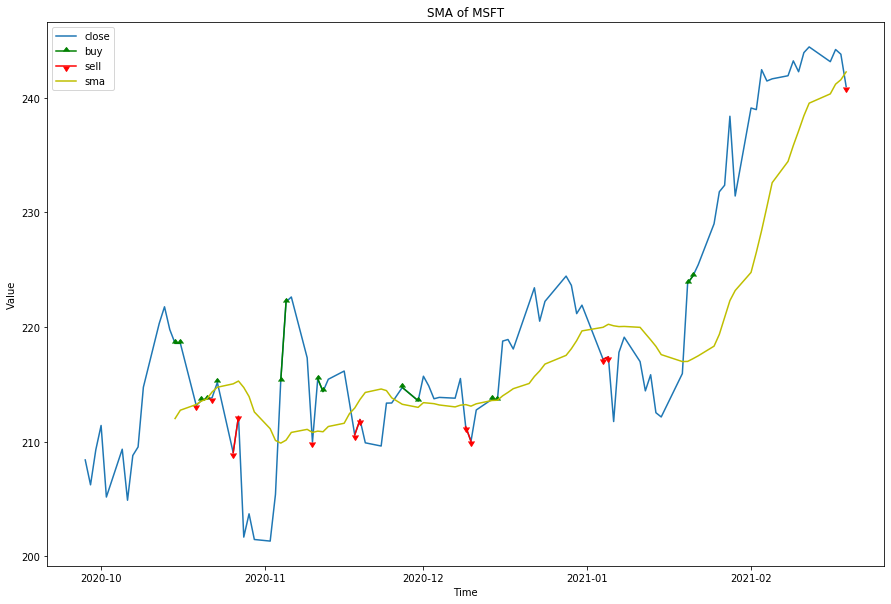

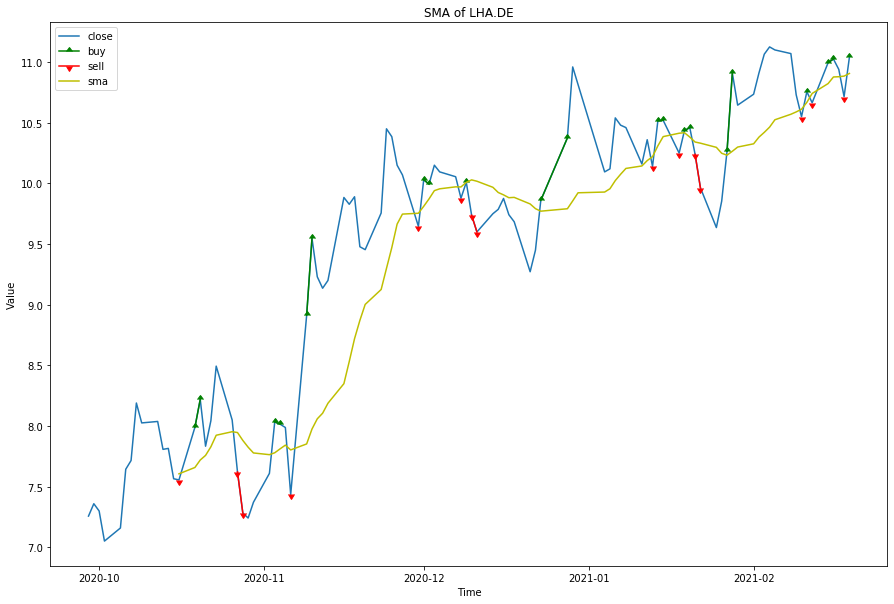

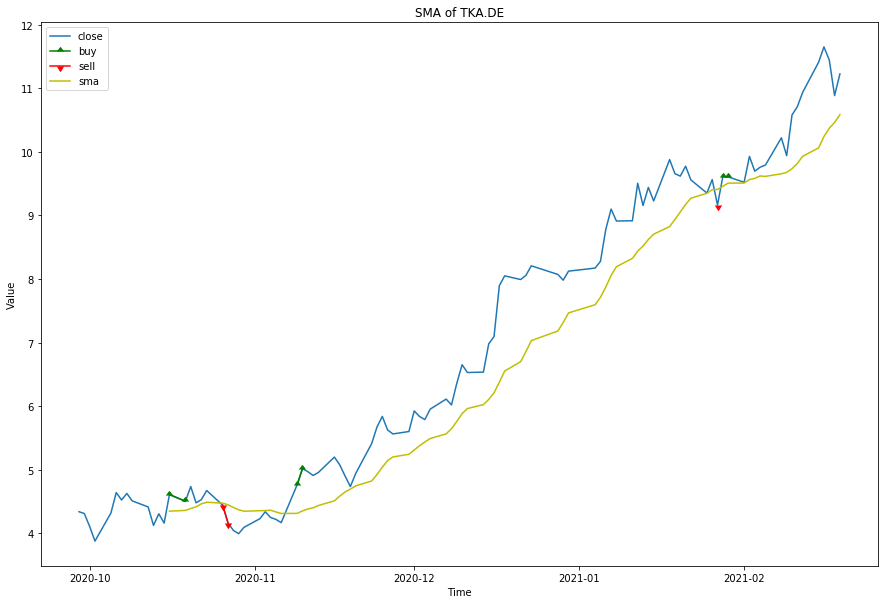

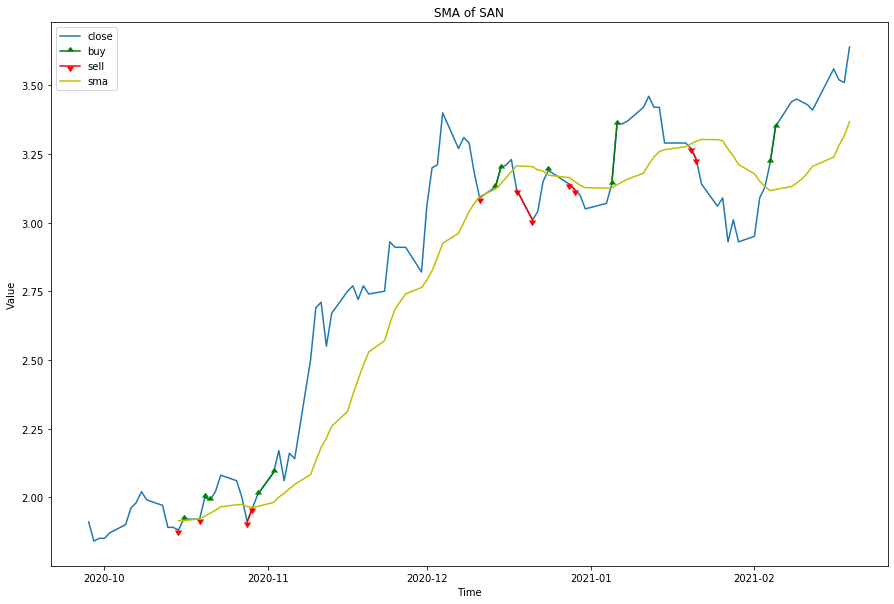

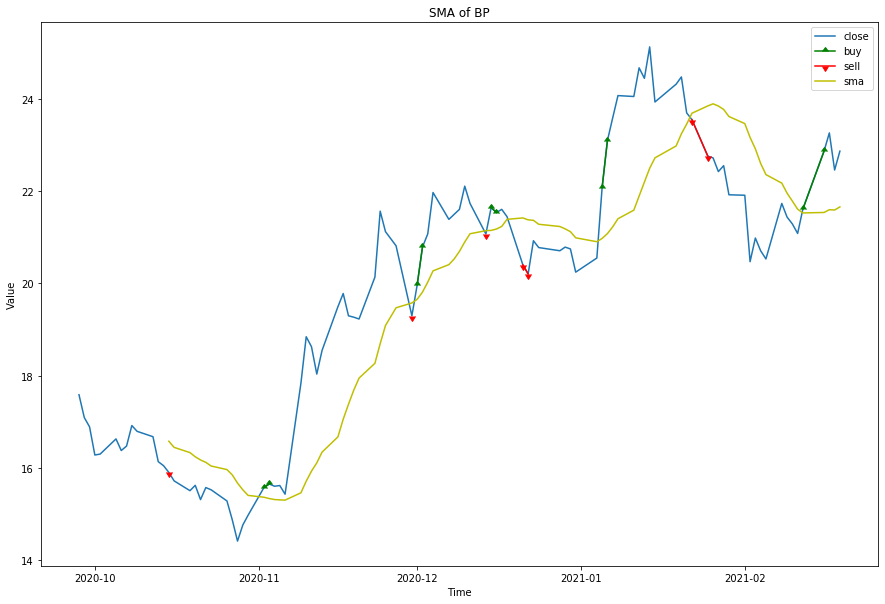

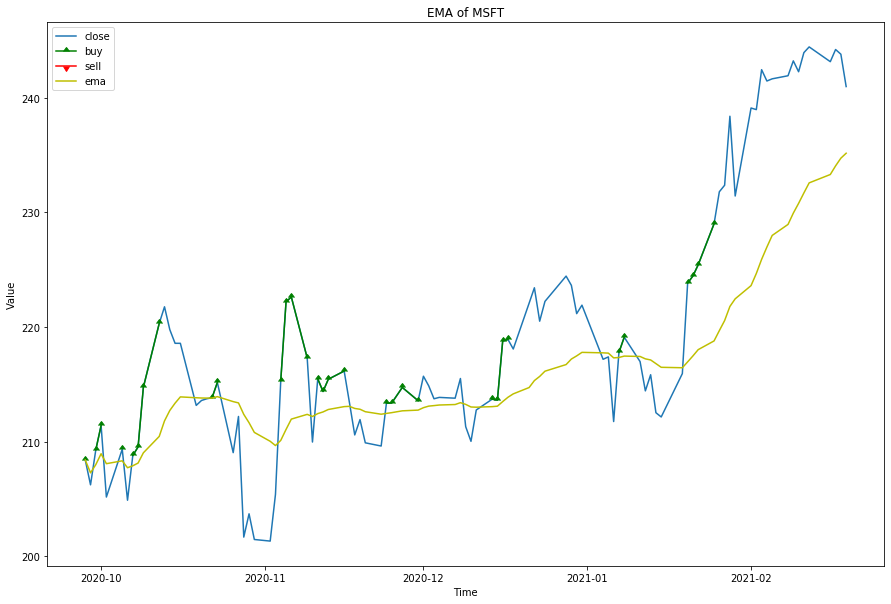

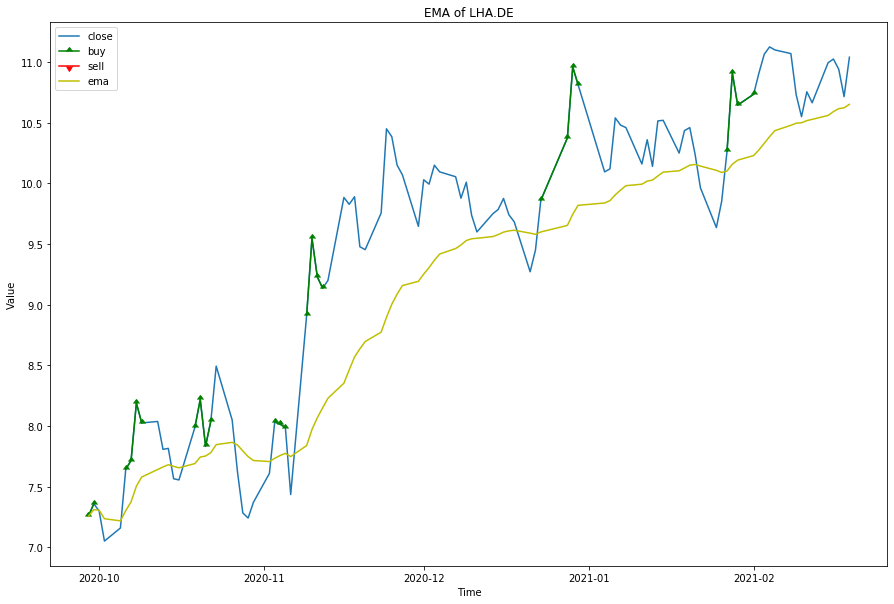

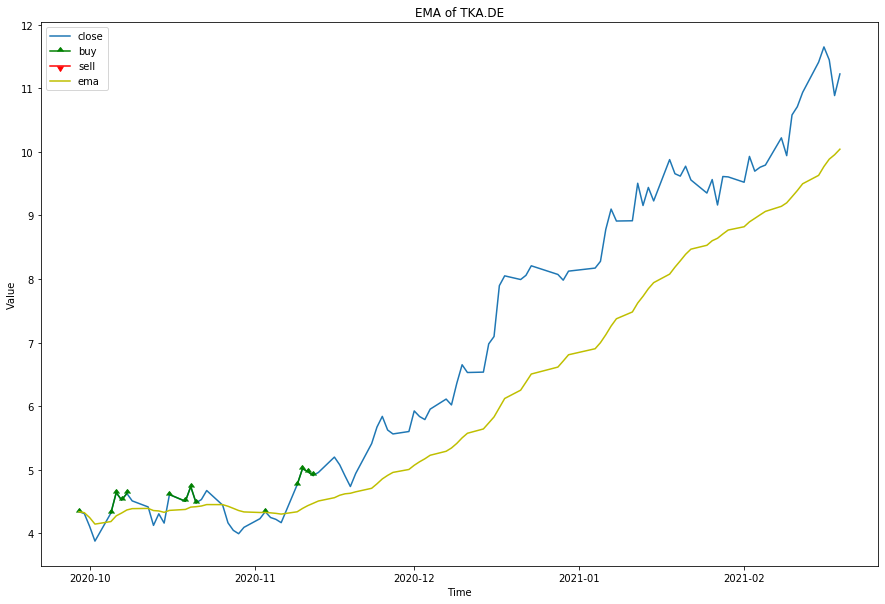

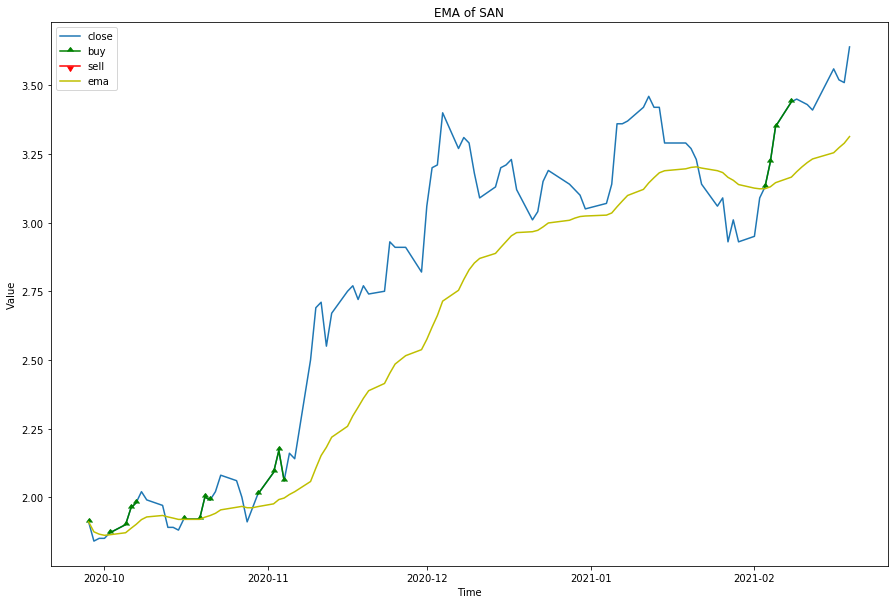

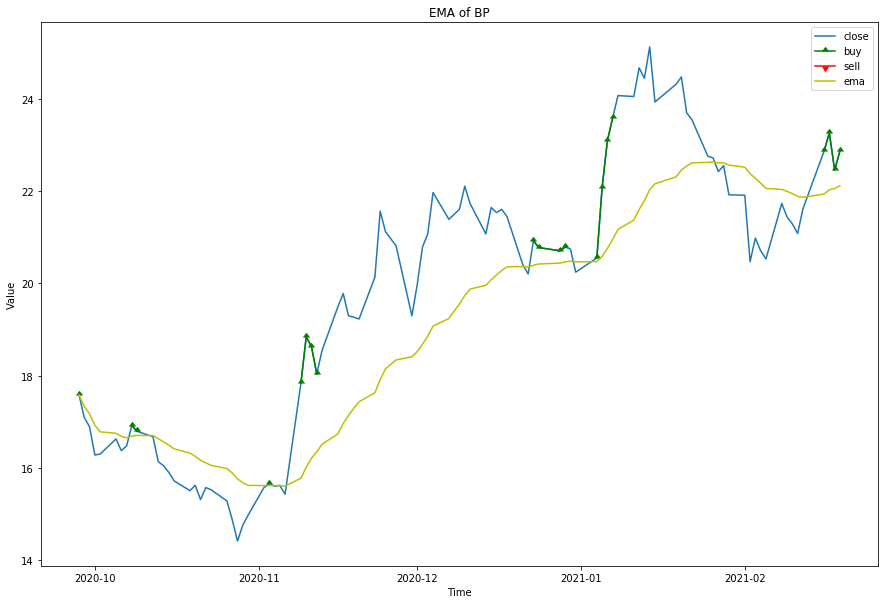

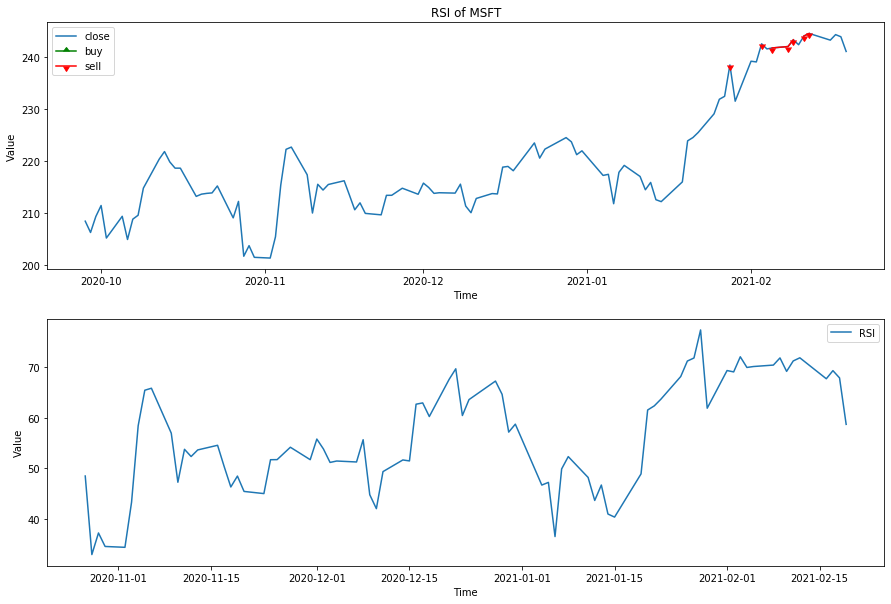

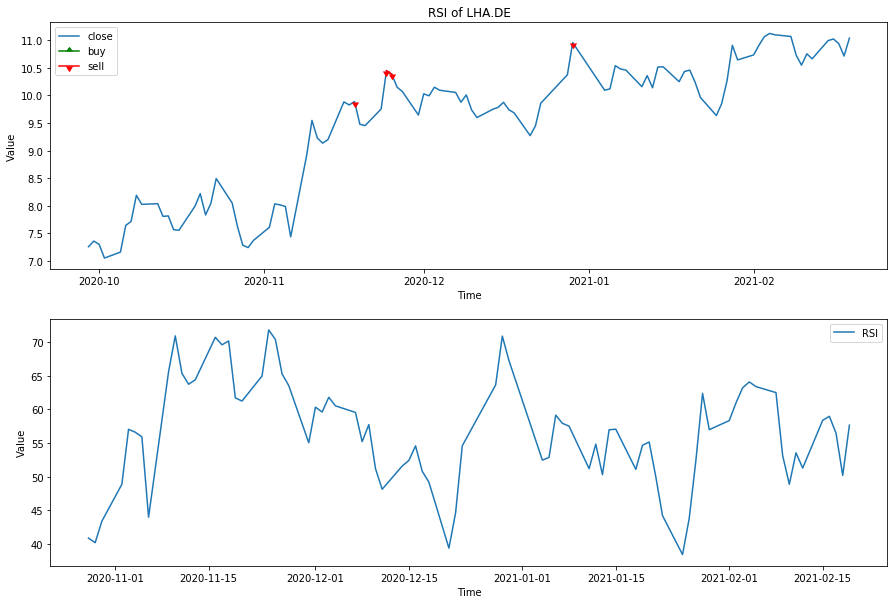

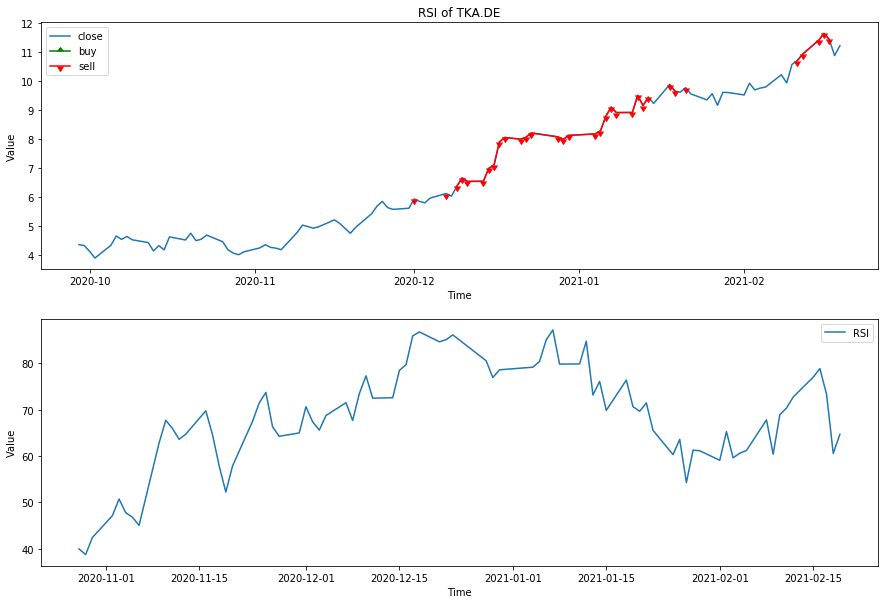

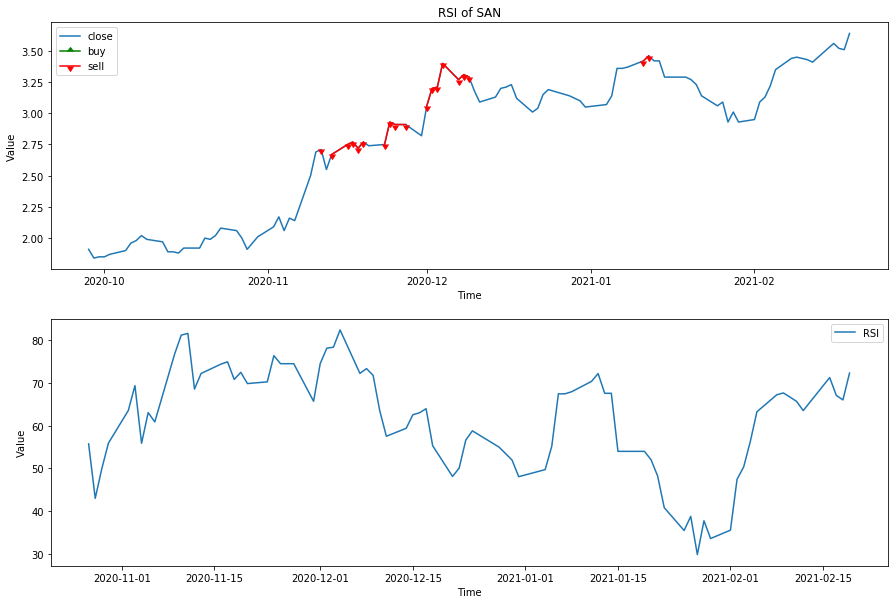

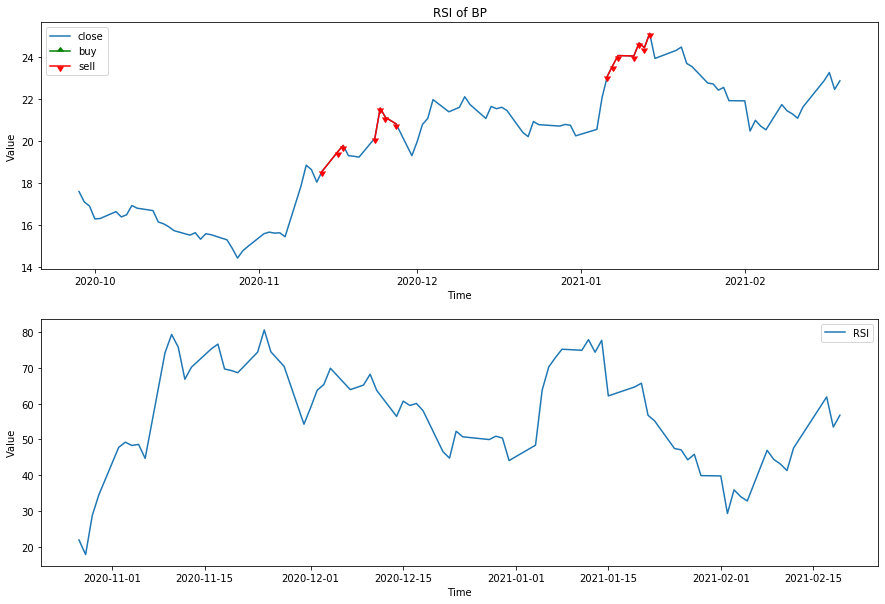

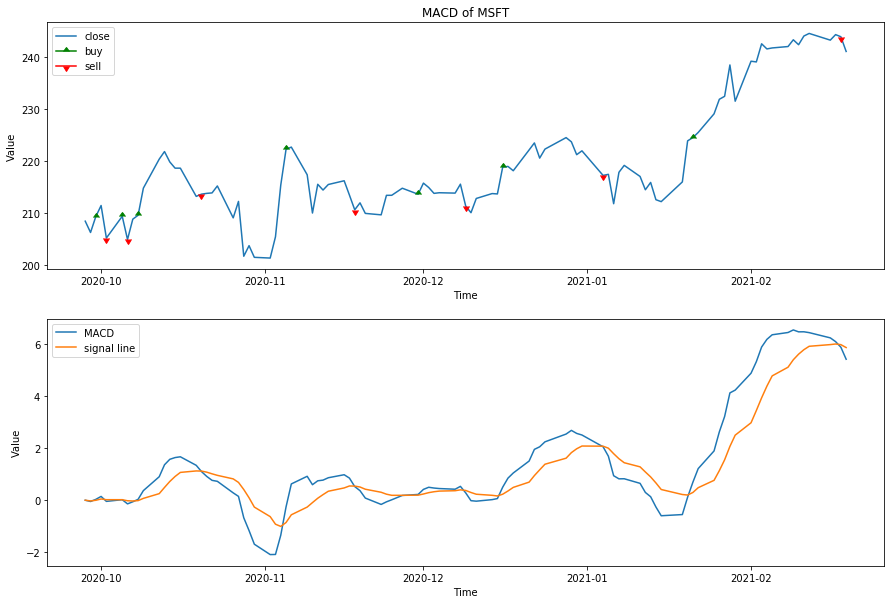

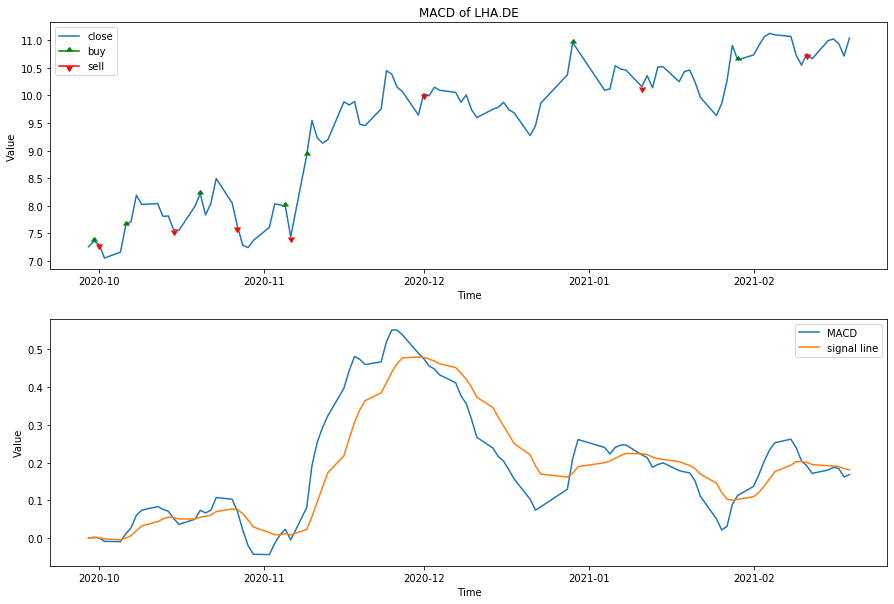

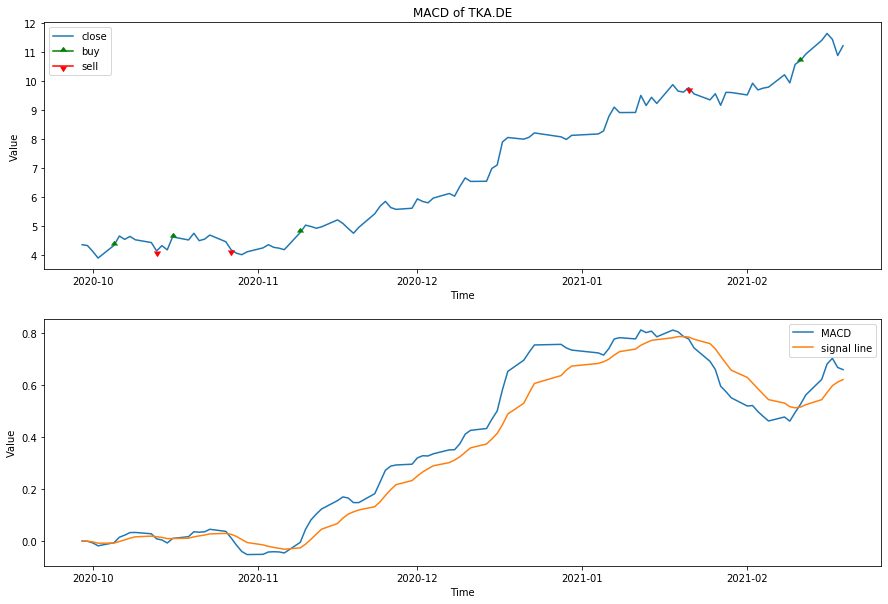

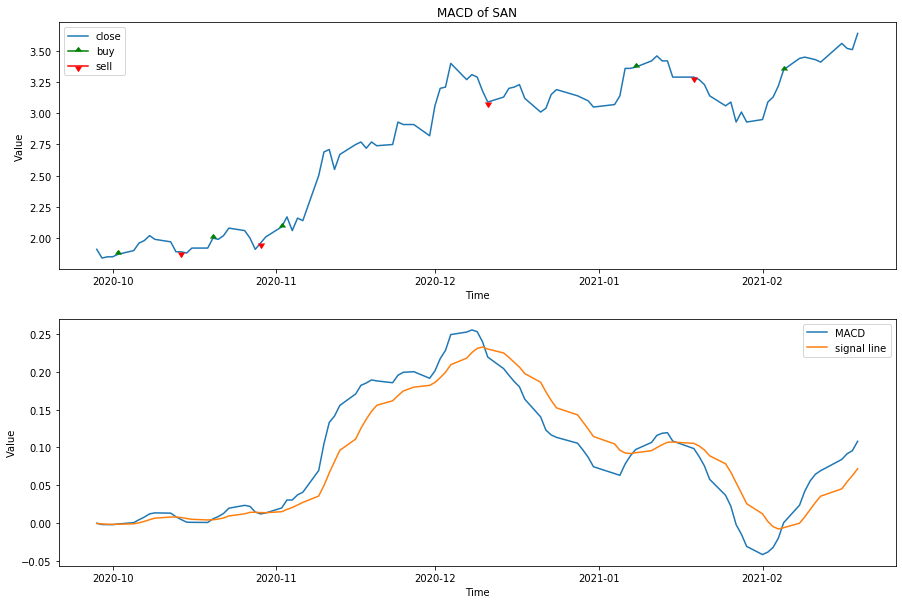

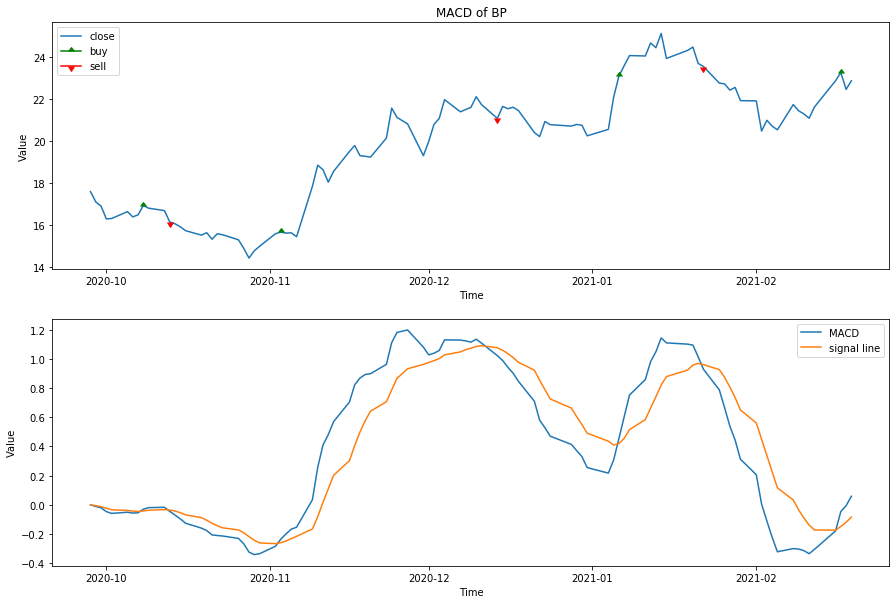

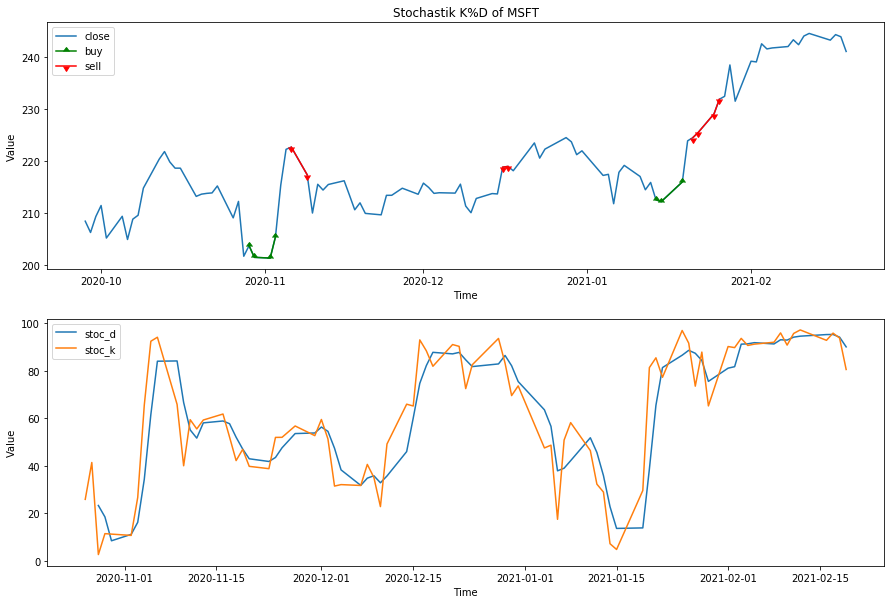

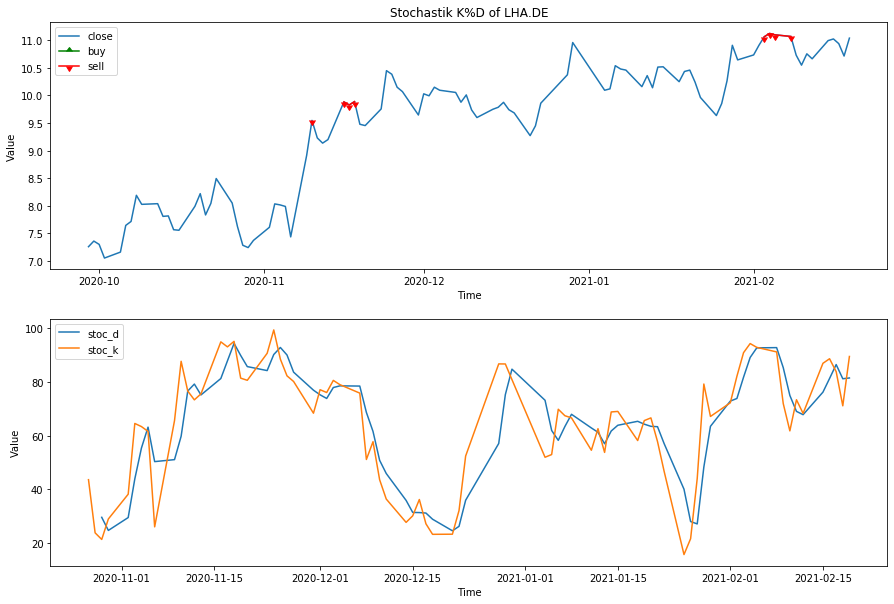

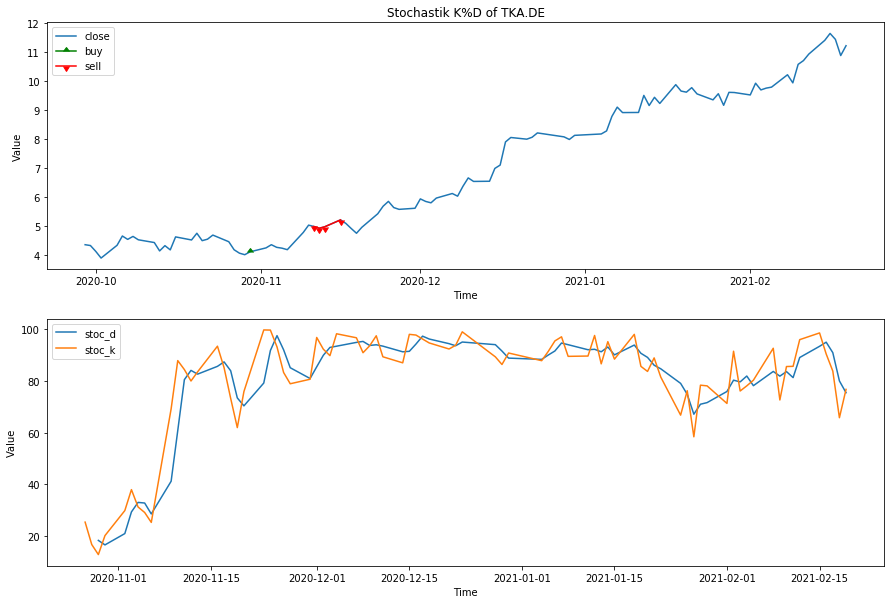

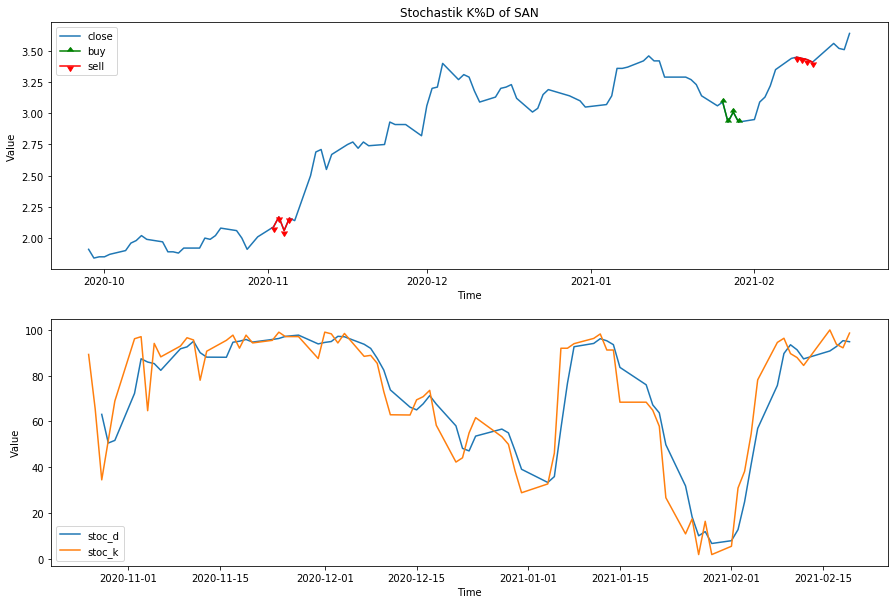

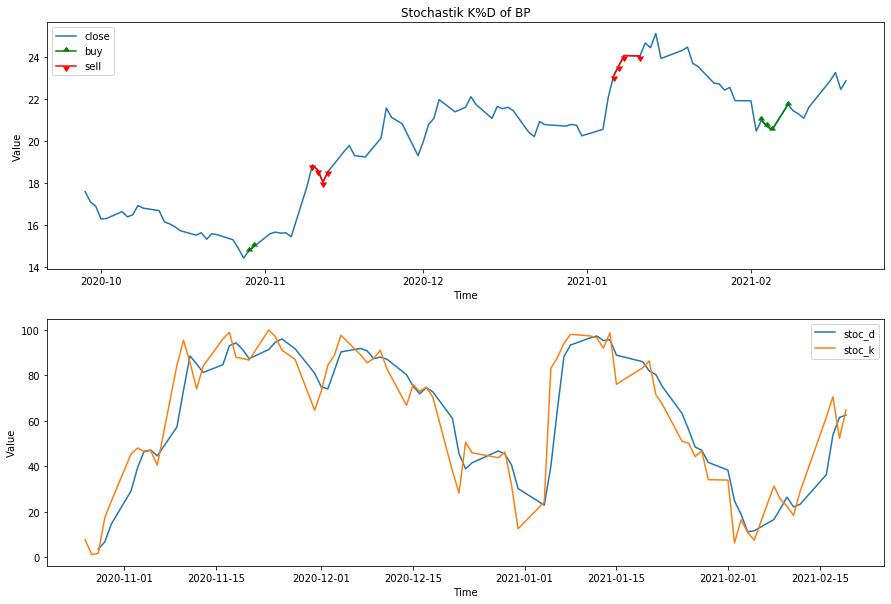

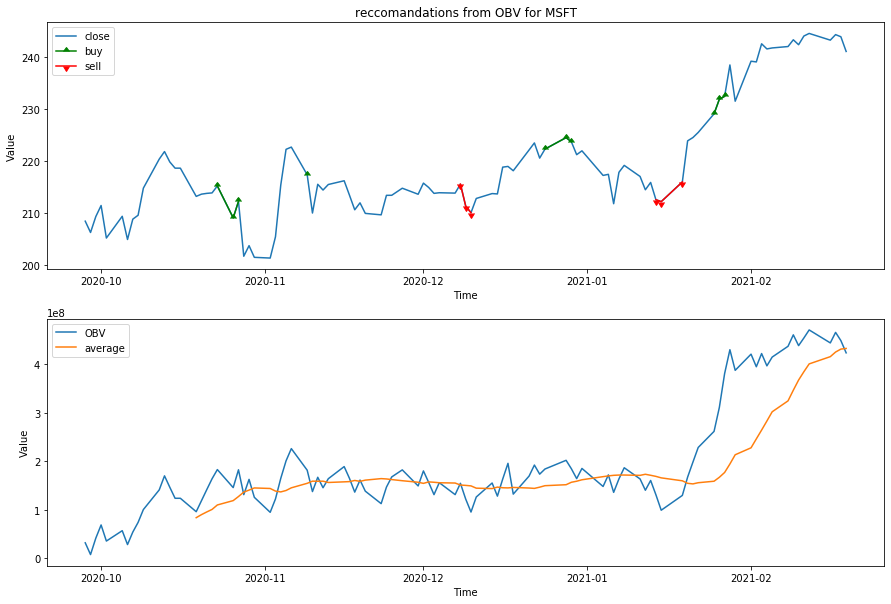

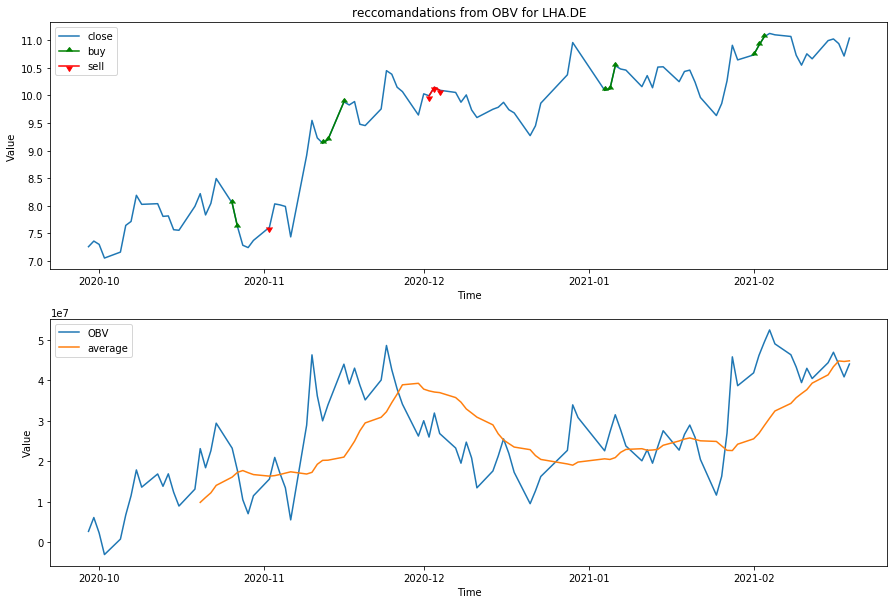

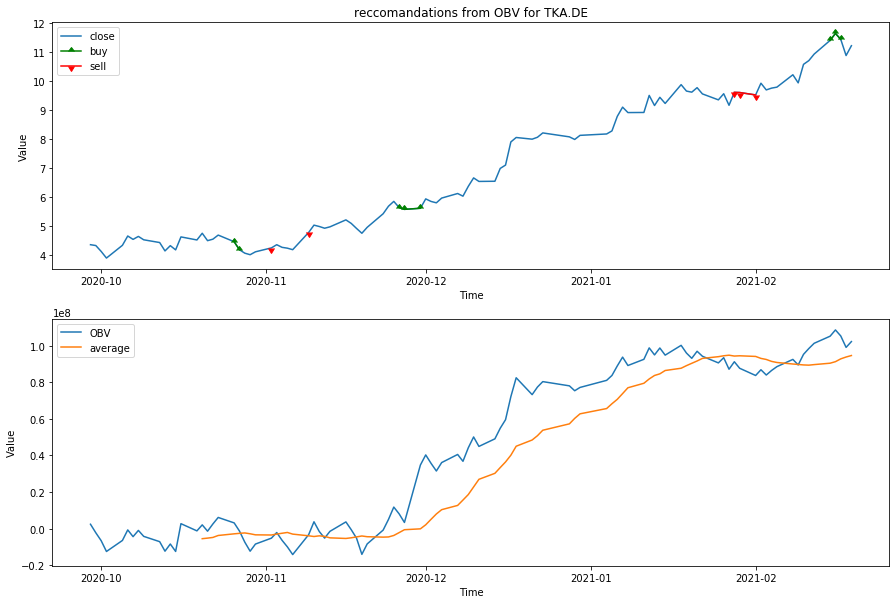

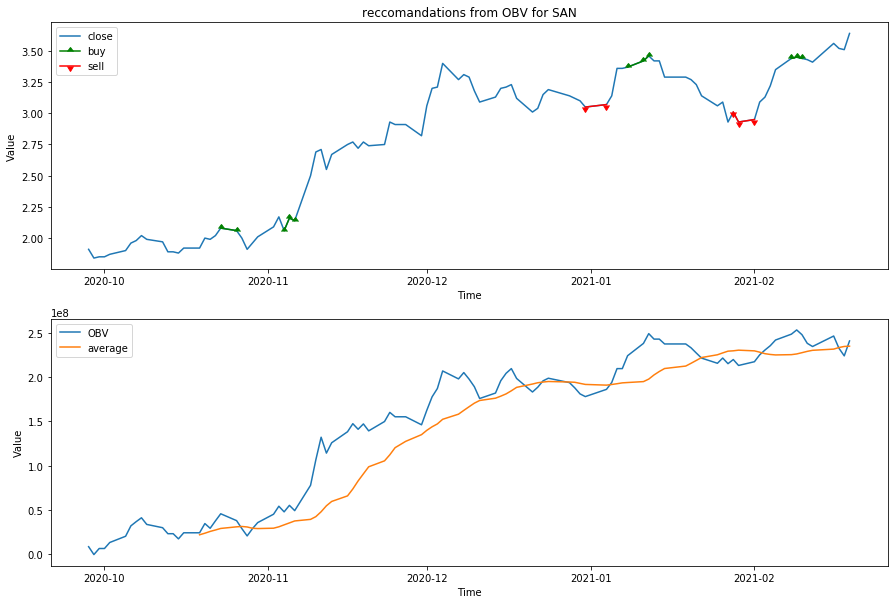

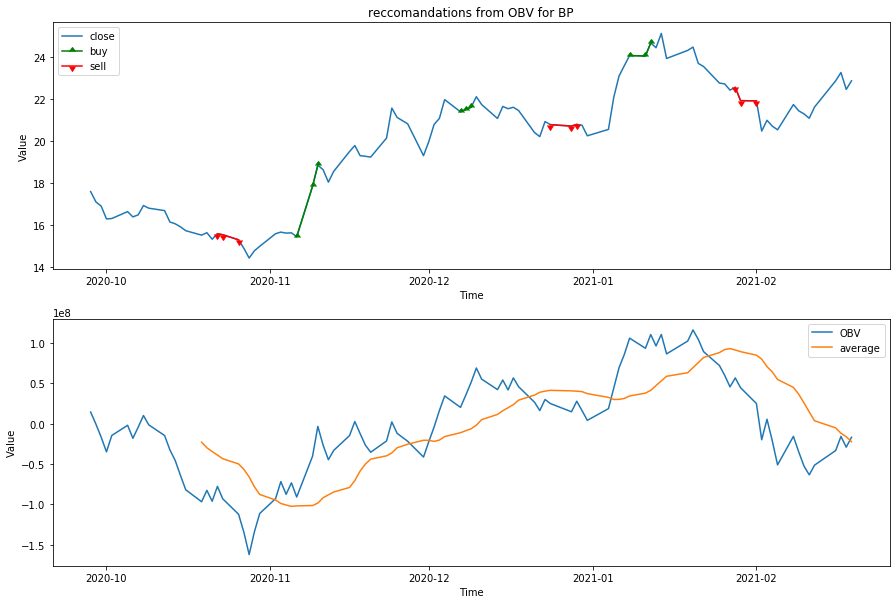

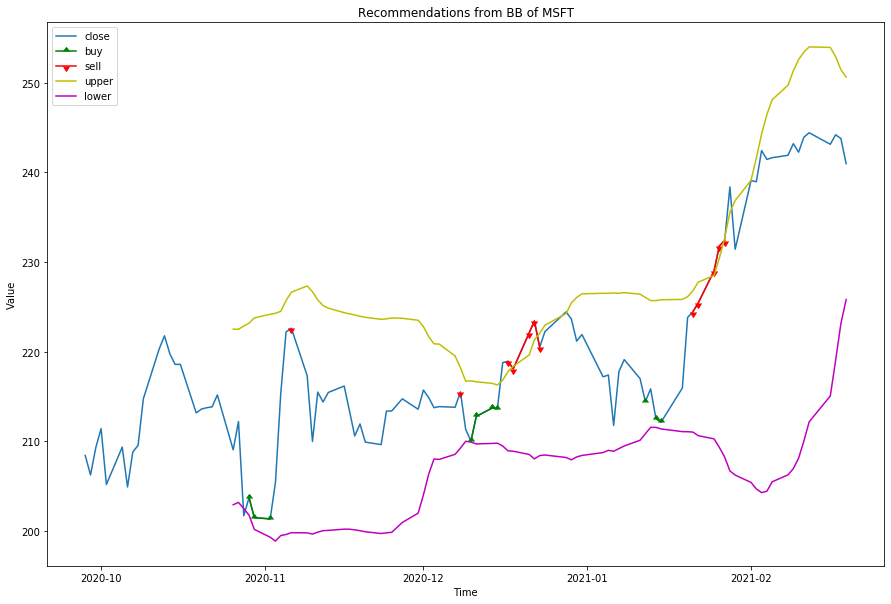

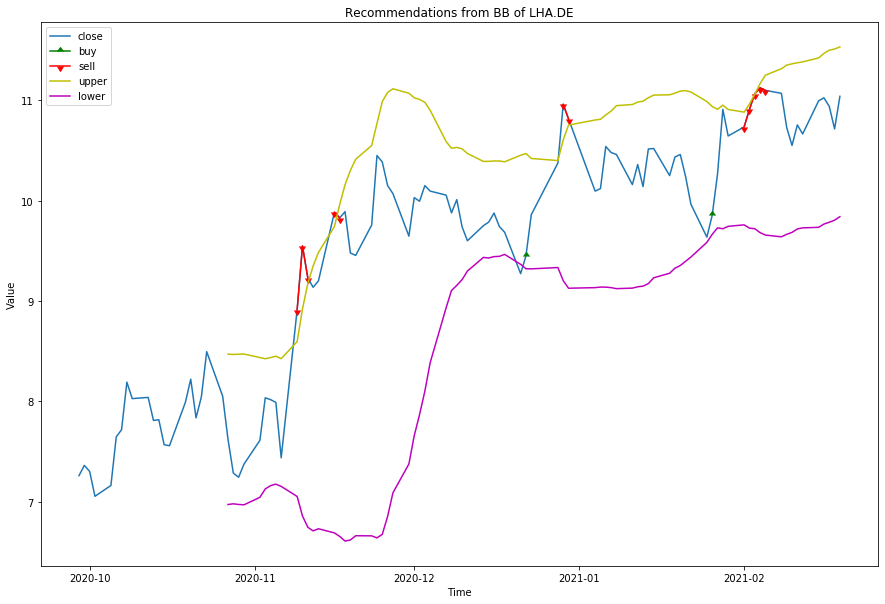

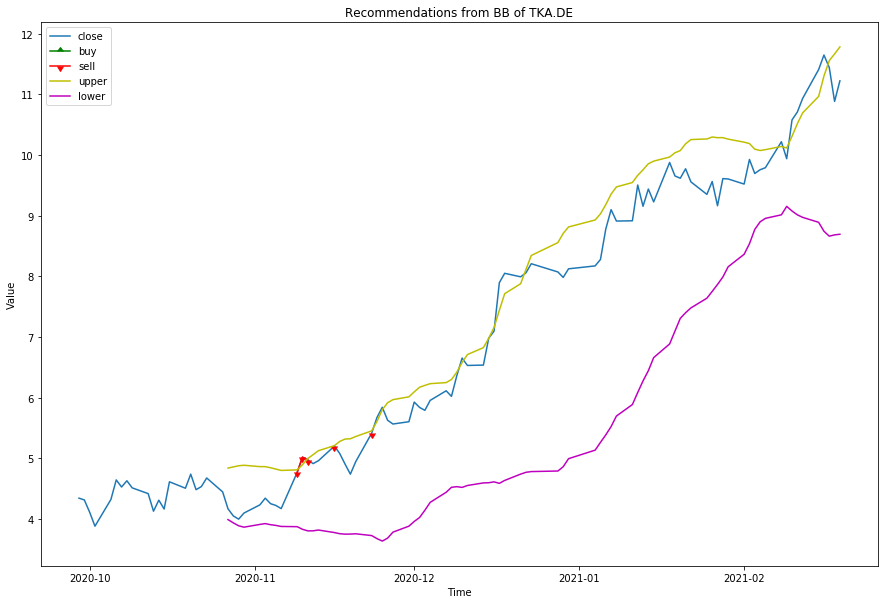

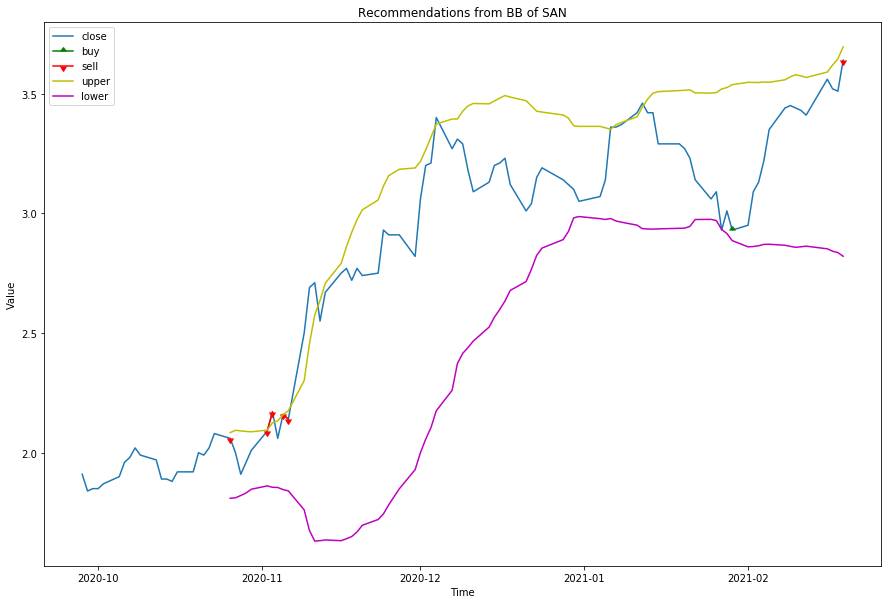

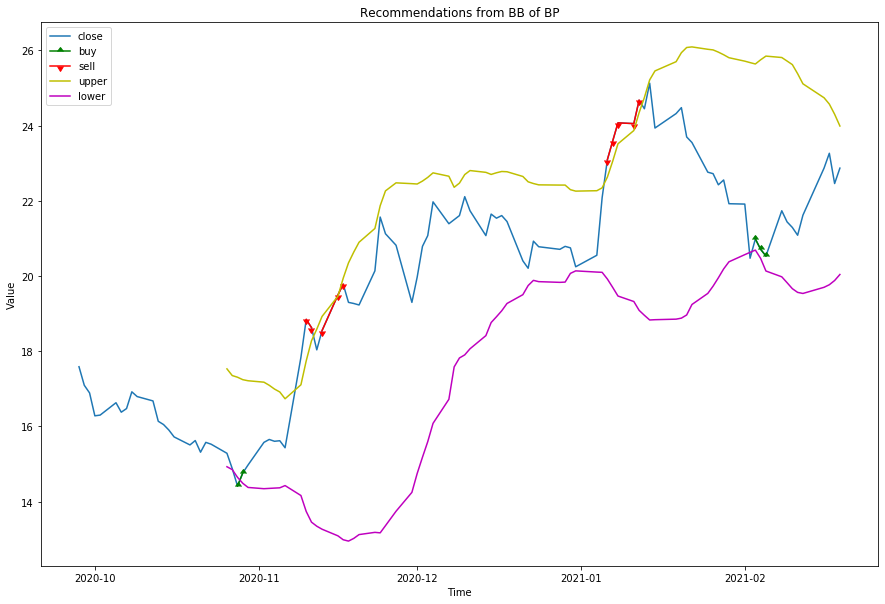

In [19]:
get_smas(stocks, names, 14)
get_ema(stocks, names, 28)
get_rsi(stocks, names, 21)
get_macd(stocks, names, 21)
get_stoch(stocks, names, 21)
get_obv(stocks, names, 14)
get_bb(stocks, names, 21)

# stoch keine ahnung ob überhaupt


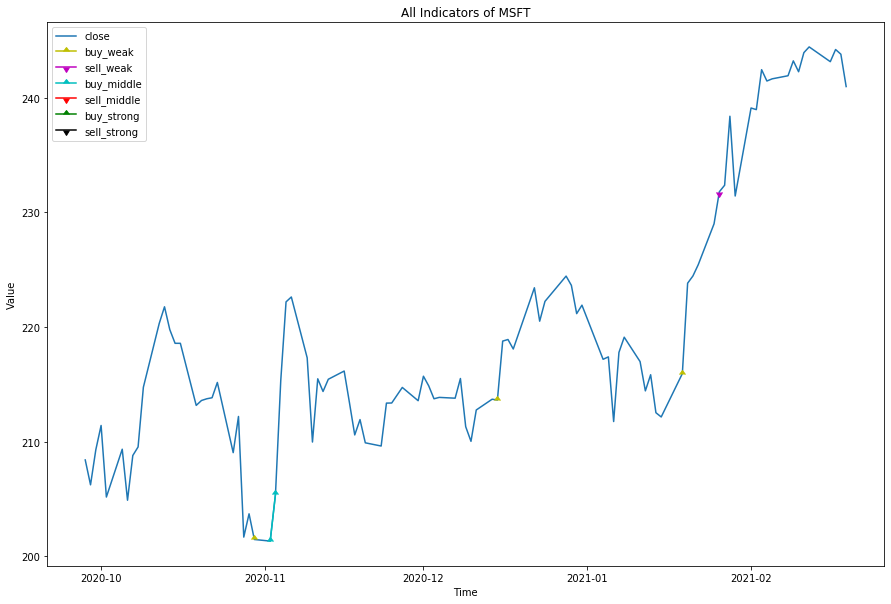

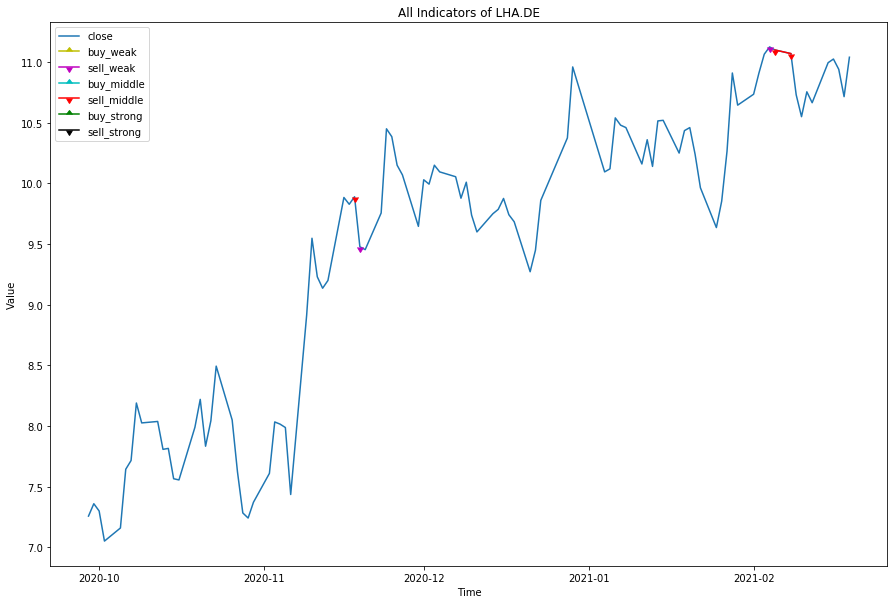

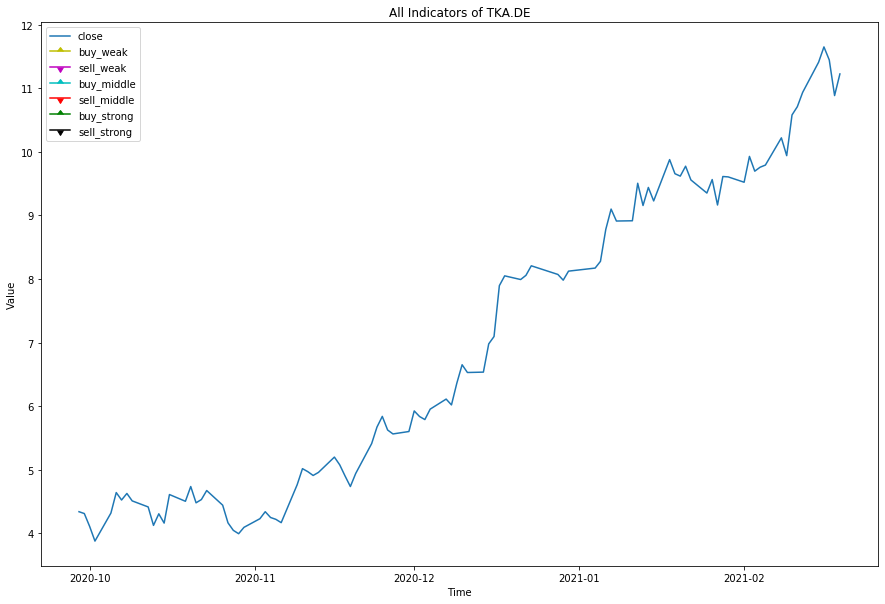

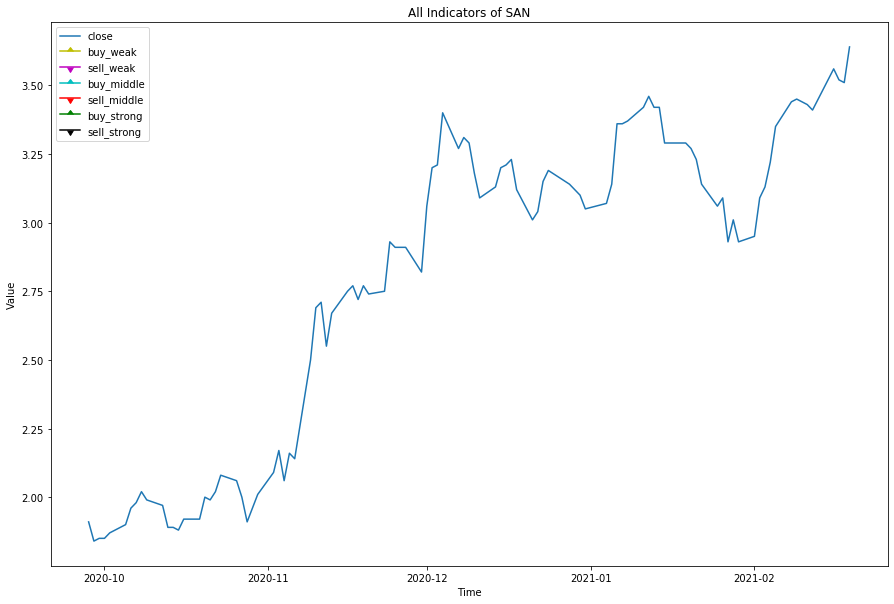

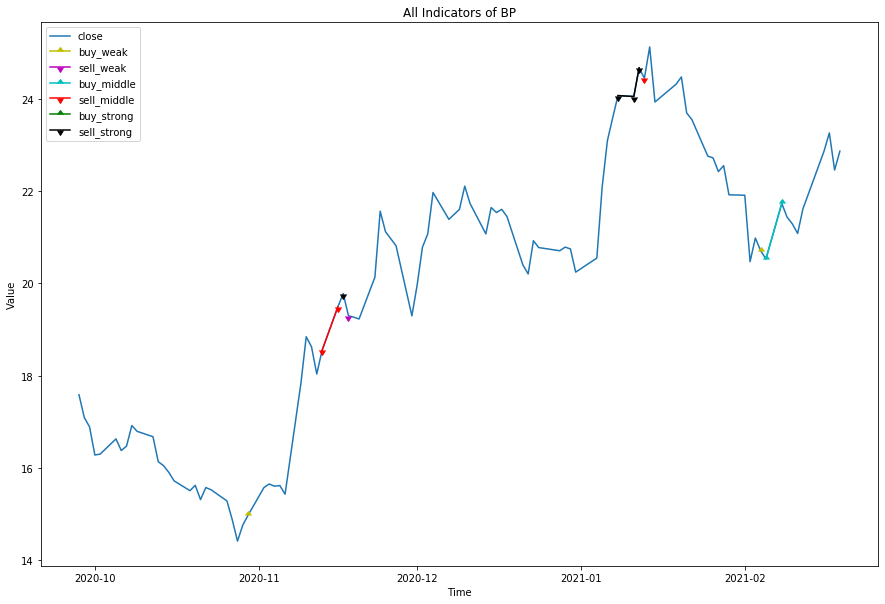

In [21]:
merge(stocks, names)

In [ ]:
# init the trading values
StartKapital = 5000
def evaluate_modell(stocks, names):
    counter = 0
    performance_gesamt = 0
    StartKapital = 5000
    for stock in stocks:
        stock=stock[["close","buy_weak","buy_middle","buy_strong","sell_weak","sell_middle","sell_strong","hold"]]
        Aktien = 0
        Angelegt = 0 
        Kapital = 5000
        #print(stock)
        length=len(stock["close"])
        #print(length)
        for day in range(length):
            #print(stock.iloc[0])
            # only 1 value can be set, check which one it is and trade accordingly
            if not (math.isnan(stock.iloc[day]["sell_weak"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_weak", stock.iloc[day]["sell_weak"], StartKapital)
            elif not (math.isnan(stock.iloc[day]["sell_middle"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_middle", stock.iloc[day]["sell_middle"], StartKapital)
            elif not (math.isnan(stock.iloc[day]["sell_strong"])) and Aktien > 0:
                Kapital,Aktien = trade(Kapital, Aktien, "sell_strong", stock.iloc[day]["sell_strong"], StartKapital)
            elif not (math.isnan(stock.iloc[day]["buy_weak"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_weak", stock.iloc[day]["buy_weak"], StartKapital)
            elif not (math.isnan(stock.iloc[day]["buy_middle"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_middle", stock.iloc[day]["buy_middle"], StartKapital)
            elif not (math.isnan(stock.iloc[day]["buy_strong"])):
                Kapital,Aktien = trade(Kapital, Aktien, "buy_strong", stock.iloc[day]["buy_strong"], StartKapital)
            else:
                Kapital,Aktien = trade(Kapital, Aktien, "hold", stock.iloc[day]["hold"], StartKapital)       
            if Kapital < 0 or Aktien < 0:
                print("that is illigal")
                print(Kapital, Aktien)
        # print share performance  
        print("Performance for "+names[counter])
        performance_gesamt+=print_result(Kapital, Aktien, stock.iloc[length-1:length]["close"][0])
        counter+=1
    print("Gesamtperformance: ")
    print(str(((performance_gesamt/(StartKapital*len(stocks)))-1)*100)+ "%")

def trade(Kapital, Aktien, signal, value, StartKapital):
    if signal == "sell_weak": 
        verkauft = round(0.1*Aktien)
        if verkauft > 0 and verkauft*value + (Aktien-verkauft)*value >= StartKapital*0.9:
            Kapital+=verkauft*value
            Aktien-=verkauft
            return Kapital, Aktien
        return Kapital, Aktien
        #print("sell_weak")
    if signal == "sell_middle":
        verkauft = round(0.3*Aktien)
        if verkauft > 0 and verkauft*value + (Aktien-verkauft)*value >= StartKapital*0.9:
            Kapital+=verkauft*value
            Aktien-=verkauft
            return Kapital, Aktien
        return Kapital, Aktien
        #print("sell_middle")
    if signal == "sell_strong":
        verkauft = round(0.5*Aktien)
        if verkauft > 0 and verkauft*value + (Aktien-verkauft)*value >= StartKapital*0.9:
            Kapital+=verkauft*value
            Aktien-=verkauft
            return Kapital, Aktien
        return Kapital, Aktien
    if signal == "buy_weak":
        kaufwert = 0.15*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        #print("buy_weak")
    if signal == "buy_middle":
        kaufwert = 0.5*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        #print("buy_middle")
    if signal == "buy_strong":
        kaufwert = 0.70*StartKapital
        if Kapital > round(kaufwert) and kaufwert > value:
            anzahl = math.floor(kaufwert/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien
        else:
            anzahl = math.floor(Kapital/value)
            Kapital-=anzahl*value
            Aktien+=anzahl
            return Kapital, Aktien            
        #print("buy_strong")
    if signal == "hold":
        return Kapital, Aktien
    
def print_result(Kapital, Aktien, value):
    gesamt = Kapital + Aktien*value
    print("Vermögen gesamt: "+ str(gesamt))
    print("anstieg in Prozent: "+ str((gesamt/StartKapital-1)*100)+ " %")
    print("Kapital: "+ str(Kapital))
    print("Aktien * value: "+ str(Aktien) +" * " + str(value))
    print("################################")
    return gesamt

In [100]:
# init the trading values
StartKapital = 5000
def evaluate_modell_new(stocks, names):
    Kapital = StartKapital
    aktien_list = [[msft, 0], [lh, 0], [thyssen, 0], [san, 0], [bp, 0]]
    length=len(stocks[0]["close"])
    for day in range(length):
        #print("Day " + str(day+1))
        signal_aktien = [[msft, ""], [lh, ""], [thyssen, ""], [san, ""], [bp, ""]]
        count_aktie = 0
        for stock in stocks:
            stock=stock[["close","buy_weak","buy_middle","buy_strong","sell_weak","sell_middle","sell_strong","hold"]]
            if not (math.isnan(stock.iloc[day]["sell_weak"])):
                signal_aktien[count_aktie][1] = "sell_weak"
            elif not (math.isnan(stock.iloc[day]["sell_middle"])):
                signal_aktien[count_aktie][1] = "sell_middle"
            elif not (math.isnan(stock.iloc[day]["sell_strong"])):
                signal_aktien[count_aktie][1] = "sell_strong"
            elif not (math.isnan(stock.iloc[day]["buy_weak"])):
                signal_aktien[count_aktie][1] = "buy_weak"
            elif not (math.isnan(stock.iloc[day]["buy_middle"])):
                signal_aktien[count_aktie][1] = "buy_middle"
            elif not (math.isnan(stock.iloc[day]["buy_strong"])):
                signal_aktien[count_aktie][1] = "buy_strong"
            else:
                signal_aktien[count_aktie][1] = ["hold"]
            count_aktie += 1
        
        aktie_numbers = contains(signal_aktien, "sell_strong")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = sell(Kapital, aktien_list[aktie_number][1], 0.5, stock.iloc[day]["sell_strong"])
            
        aktie_numbers = contains(signal_aktien, "sell_middle")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = sell(Kapital, aktien_list[aktie_number][1], 0.3, stock.iloc[day]["sell_middle"])
        
        aktie_numbers = contains(signal_aktien, "sell_weak")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = sell(Kapital, aktien_list[aktie_number][1], 0.1, stock.iloc[day]["sell_weak"])
            
        aktie_numbers = contains(signal_aktien, "buy_strong")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = buy(Kapital, aktien_list[aktie_number][1], 0.5, stock.iloc[day]["buy_strong"])
        
        aktie_numbers = contains(signal_aktien, "buy_middle")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = buy(Kapital, aktien_list[aktie_number][1], 0.3, stock.iloc[day]["buy_middle"])
            
        aktie_numbers = contains(signal_aktien, "buy_weak")
        for aktie_number in aktie_numbers:
            Kapital, aktien_list[aktie_number][1] = buy(Kapital, aktien_list[aktie_number][1], 0.1, stock.iloc[day]["buy_weak"])
            print("Test")
    print(Kapital)
        
def buy (Kapital, Aktien, prozent_kapital, value):
    kaufwert = prozent_kapital*Kapital
    if Kapital > round(kaufwert) and kaufwert > value:
        anzahl = math.floor(kaufwert/value)
        Kapital-=anzahl*value
        Aktien+=anzahl
        return Kapital, Aktien
    #else:
     #   print(Kapital)
      #  print(value)
       # anzahl = math.floor(Kapital/value)
        #Kapital-=anzahl*value
        #Aktien+=anzahl
        #return Kapital, Aktien

def sell(Kapital, Aktien, prozent_aktie, value):
    aktien_number = round(prozent_aktie*Aktien)
    if aktien_number < 0:
        aktien_number += 1
    Kapital += aktien_number*value
    Aktien -= verkauft
    return Kapital, Aktien
        
def contains(signal_aktien, signal):
    count_list = []
    count = 0
    for signal_aktie in signal_aktien:
        if signal_aktie[1] == signal:
            count_list.extend([count])
    return count_list
    

In [101]:
evaluate_modell_new(stocks, names)

Test
Test
4056.578881263733
nan


ValueError: cannot convert float NaN to integer

In [28]:
evaluate_modell(stocks, names)

Performance for MSFT
Vermögen gesamt: 5927.584365844727
anstieg in Prozent: 18.551687316894537 %
Kapital: 594.3444061279297
Aktien * value: 22 * 242.4199981689453
################################
Performance for LHA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.71500015258789
################################
Performance for TKA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.885000228881836
################################
Performance for SAN
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 3.4786999225616455
################################
Performance for BP
Vermögen gesamt: 7179.318016052246
anstieg in Prozent: 43.58636032104493 %
Kapital: 2.725910186767578
Aktien * value: 318 * 22.567899703979492
################################
Gesamtperformance: 
12.4276095275879%


In [29]:
evaluate_modell(stocks, names)

Performance for MSFT
Vermögen gesamt: 5927.584365844727
anstieg in Prozent: 18.551687316894537 %
Kapital: 594.3444061279297
Aktien * value: 22 * 242.4199981689453
################################
Performance for LHA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.71500015258789
################################
Performance for TKA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.885000228881836
################################
Performance for SAN
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 3.4786999225616455
################################
Performance for BP
Vermögen gesamt: 7179.318016052246
anstieg in Prozent: 43.58636032104493 %
Kapital: 2.725910186767578
Aktien * value: 318 * 22.567899703979492
################################
Gesamtperformance: 
12.4276095275879%


In [30]:
evaluate_modell(stocks, names)

Performance for MSFT
Vermögen gesamt: 5927.584365844727
anstieg in Prozent: 18.551687316894537 %
Kapital: 594.3444061279297
Aktien * value: 22 * 242.4199981689453
################################
Performance for LHA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.71500015258789
################################
Performance for TKA.DE
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 10.885000228881836
################################
Performance for SAN
Vermögen gesamt: 5000.0
anstieg in Prozent: 0.0 %
Kapital: 5000
Aktien * value: 0 * 3.4786999225616455
################################
Performance for BP
Vermögen gesamt: 7179.318016052246
anstieg in Prozent: 43.58636032104493 %
Kapital: 2.725910186767578
Aktien * value: 318 * 22.567899703979492
################################
Gesamtperformance: 
12.4276095275879%


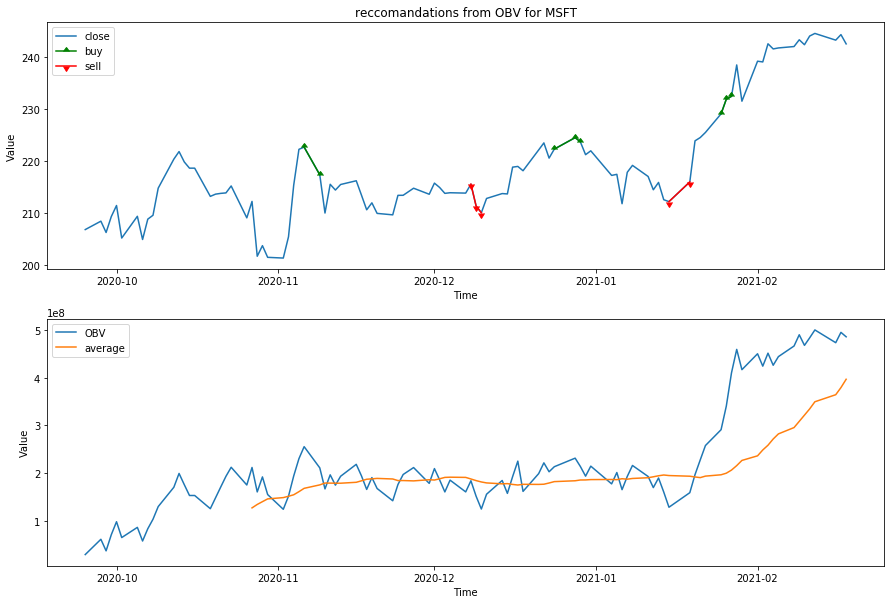

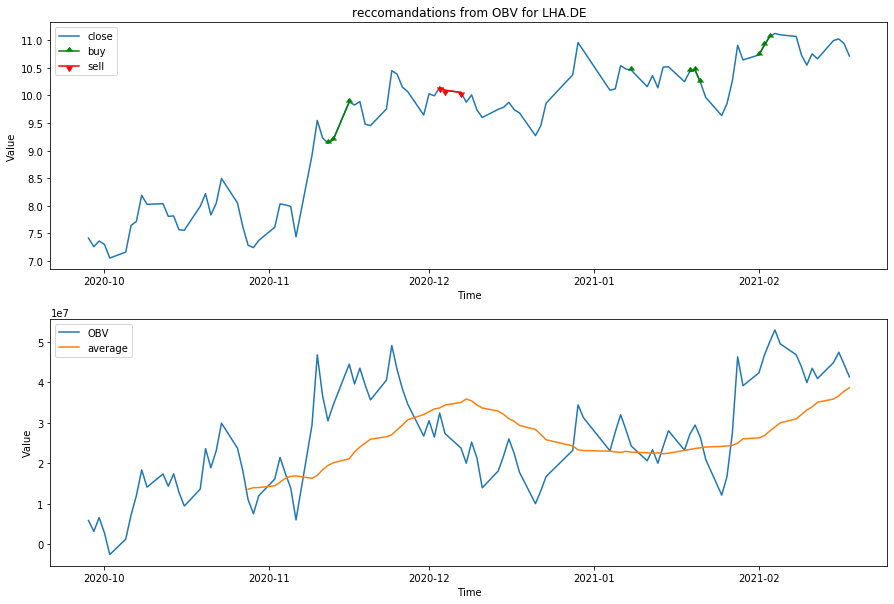

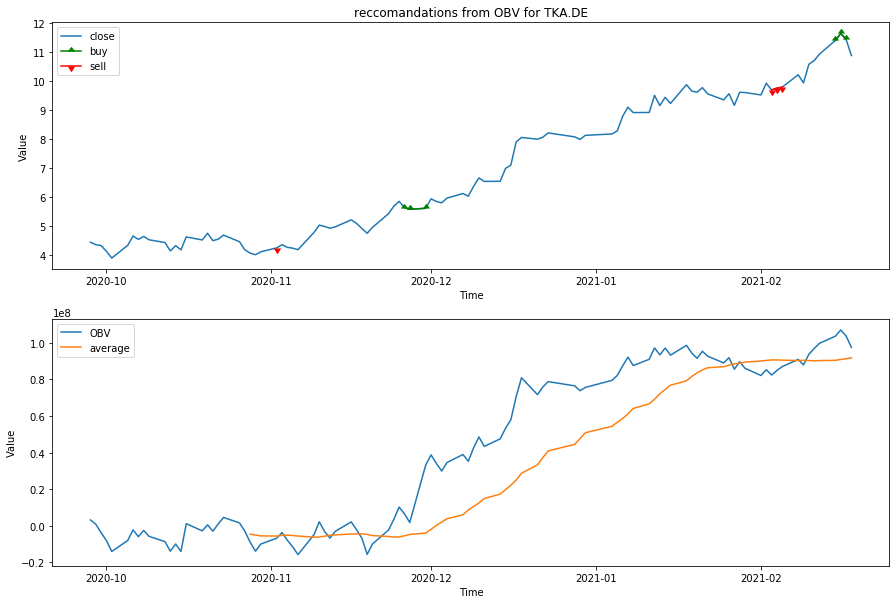

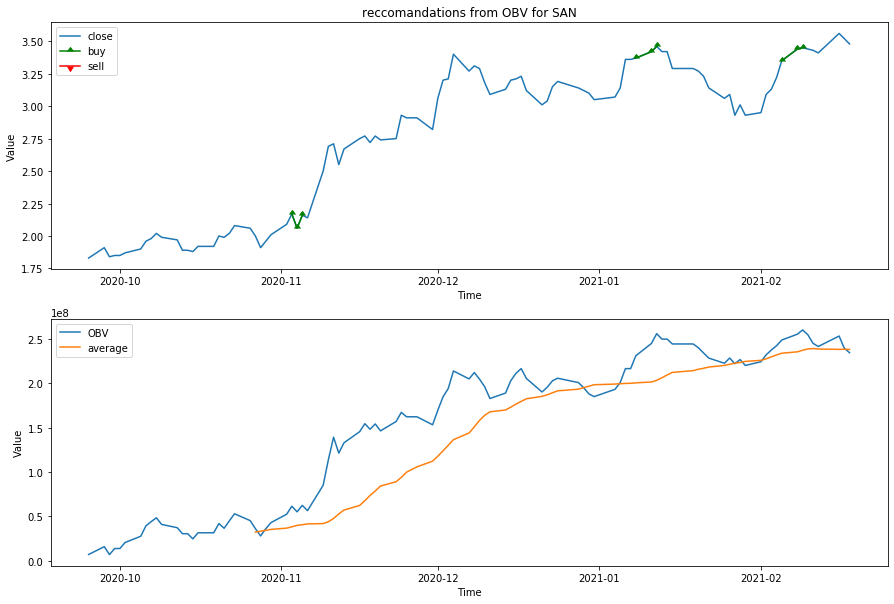

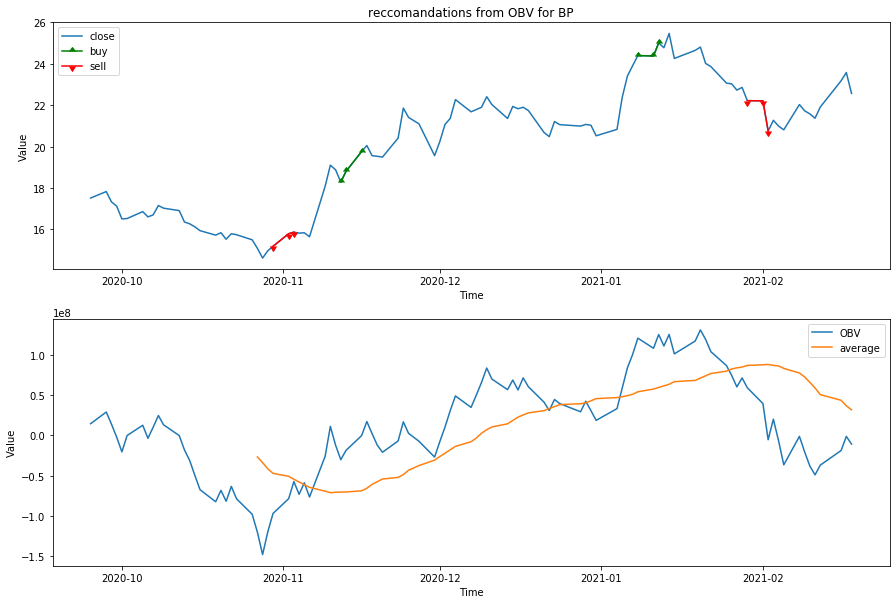

In [31]:
get_obv(stocks, names, 21)

In [32]:
stocks[0]

,open,high,low,close,volume,Dividends,Stock Splits,SMA,sma_buy,sma_sell,...,bb_buy,bb_sell,bb_trend,buy_weak,buy_middle,buy_strong,sell_weak,sell_middle,hold,sell_strong
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-25,202.551973,208.015045,201.546915,206.801041,29437300,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,206.801041,NaN
2020-09-28,209.846043,211.527759,207.039863,208.413101,32004900,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,208.413101,NaN
2020-09-29,208.323538,209.040009,205.795984,206.243774,24221900,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,206.243774,NaN
2020-09-30,206.711463,210.940625,205.527296,209.298721,33829100,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,209.298721,NaN
2020-10-01,212.443238,212.940786,210.283879,211.418289,27158400,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,211.418289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,244.217519,244.586664,241.593558,243.928192,15742200,0.00,0,238.420164,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,243.928192,NaN
2021-02-12,243.369471,244.736333,242.172231,244.427048,16552000,0.00,0,239.521913,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,244.427048,NaN
2021-02-16,244.466945,245.564423,242.361793,243.139999,26708200,0.00,0,240.332188,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,243.139999,NaN


In [33]:
list=[1,2]
len(list)

2

In [34]:
len(stocks)

5

In [35]:
stocks[0]

,open,high,low,close,volume,Dividends,Stock Splits,SMA,sma_buy,sma_sell,...,bb_buy,bb_sell,bb_trend,buy_weak,buy_middle,buy_strong,sell_weak,sell_middle,hold,sell_strong
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-25,202.551973,208.015045,201.546915,206.801041,29437300,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,206.801041,NaN
2020-09-28,209.846043,211.527759,207.039863,208.413101,32004900,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,208.413101,NaN
2020-09-29,208.323538,209.040009,205.795984,206.243774,24221900,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,206.243774,NaN
2020-09-30,206.711463,210.940625,205.527296,209.298721,33829100,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,209.298721,NaN
2020-10-01,212.443238,212.940786,210.283879,211.418289,27158400,0.00,0,NaN,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,211.418289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,244.217519,244.586664,241.593558,243.928192,15742200,0.00,0,238.420164,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,243.928192,NaN
2021-02-12,243.369471,244.736333,242.172231,244.427048,16552000,0.00,0,239.521913,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,244.427048,NaN
2021-02-16,244.466945,245.564423,242.361793,243.139999,26708200,0.00,0,240.332188,NaN,NaN,...,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN,243.139999,NaN


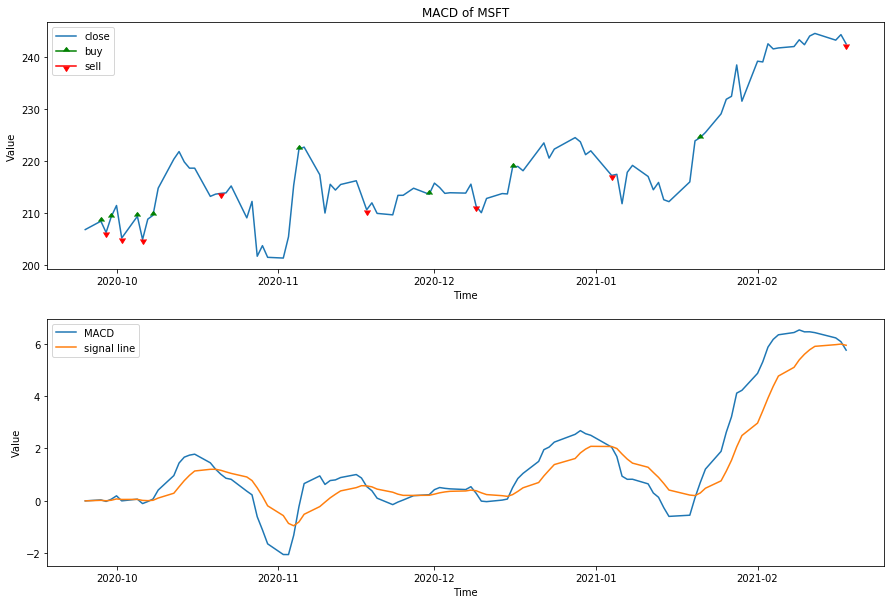

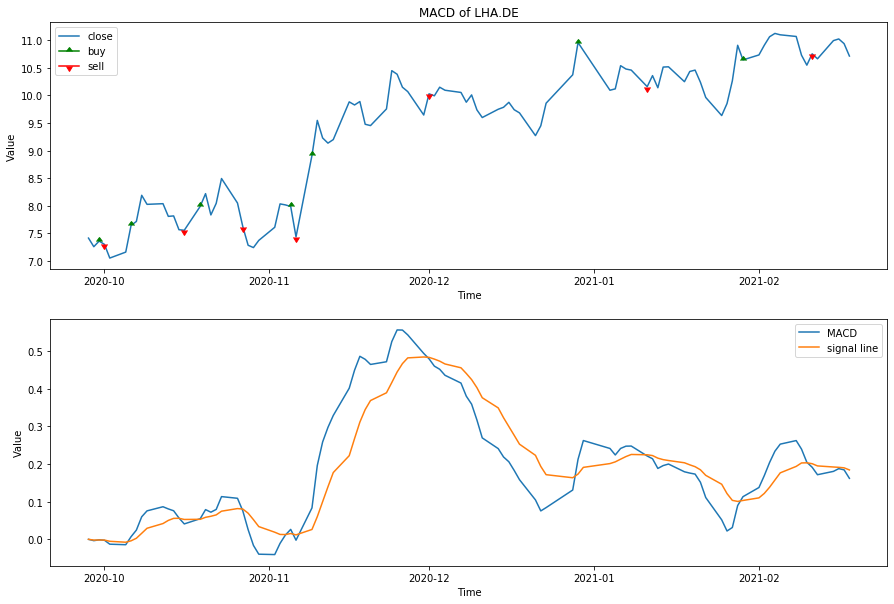

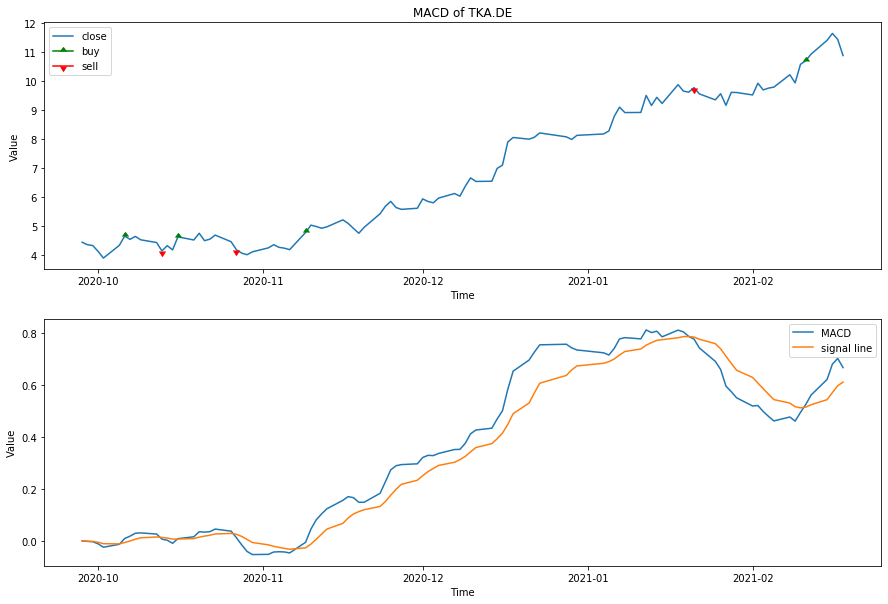

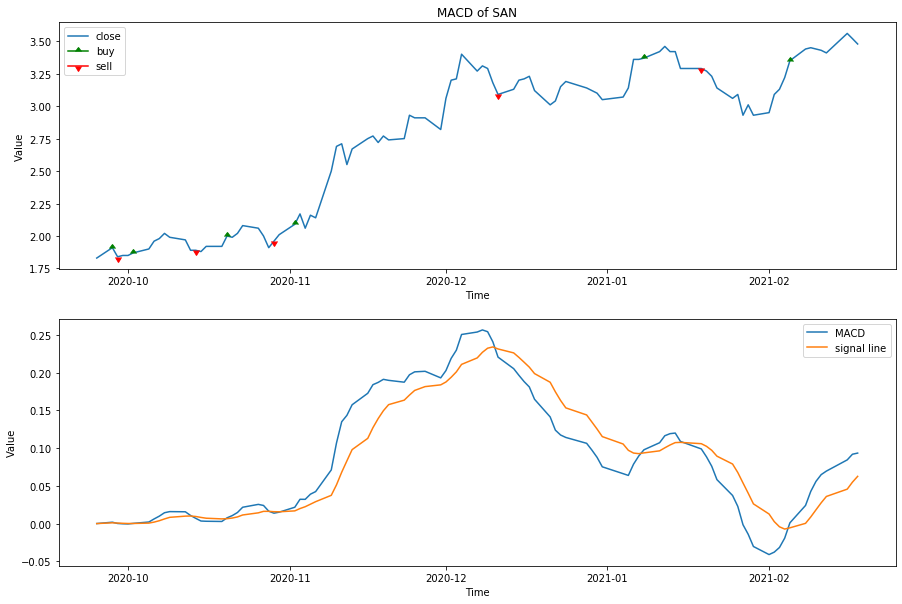

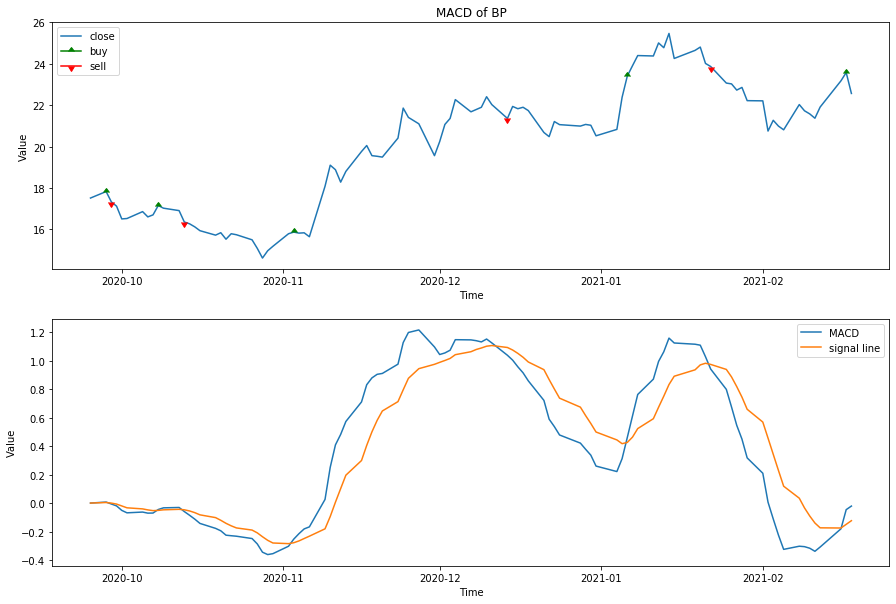

In [36]:
# todo anbindung an DB -- mehrere Portfolios?
# merge überarbeiten (gewichtung von indikatoren), 
# WilliamsR?
# anderer trading algo mit festkapital für alle aktien
# email notifire
get_macd(stocks, names, 21)
